# Microsoft Malware Prediction EDA

## File Summary
### File Size
    # train.csv
        size : 4385 MB
    # test.csv
        size : 3796 MB
    # sample_submission.csv
        size : 291 MB

## EDA

### Import

In [17]:
# system
import os
import sys
import gc
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# numerical
import numpy as np
import math

# utility
import pandas as pd
pd.set_option("display.max_columns", 100)
from dask import dataframe as dd

# visualize
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style("whitegrid")
from IPython.display import display

### Grobal Parameter

In [2]:
ROOT_PATH = Path(".").absolute().parents[1]

### Load Data

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
        https://www.kaggle.com/timon88/load-whole-data-without-any-dtypes
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
train_ddf = dd.read_csv(
    ROOT_PATH / "input" / "train.csv",
    dtype={'AVProductStatesIdentifier': 'float64', 
           'AVProductsEnabled': 'float64',
           'AVProductsInstalled': 'float64',
           'GeoNameIdentifier': 'float64',
           'IsProtected': 'float64',
           'PuaMode': 'object'}
)
train_df = reduce_mem_usage(train_ddf.compute())
display(train_df.head(30))

Memory usage of dataframe is 5717.50 MB
Memory usage after optimization is: 1749.83 MB
Decreased by 69.4%


MachineIdentifier   ProductName EngineVersion  \
0   0000028988387b115f69f31a3bf04f09  win8defender   1.1.15100.1   
1   000007535c3f730efa9ea0b7ef1bd645  win8defender   1.1.14600.4   
2   000007905a28d863f6d0d597892cd692  win8defender   1.1.15100.1   
3   00000b11598a75ea8ba1beea8459149f  win8defender   1.1.15100.1   
4   000014a5f00daa18e76b81417eeb99fc  win8defender   1.1.15100.1   
5   000016191b897145d069102325cab760  win8defender   1.1.15100.1   
6   0000161e8abf8d8b89c5ab8787fd712b  win8defender   1.1.15100.1   
7   000019515bc8f95851aff6de873405e8  win8defender   1.1.15100.1   
8   00001a027a0ab970c408182df8484fce  win8defender   1.1.15200.1   
9   00001a18d69bb60bda9779408dcf02ac  win8defender   1.1.15100.1   
10  00001b3b3cf8c8c079a272ce51031753  win8defender   1.1.15100.1   
11  00001b924fcc6922321cfadbafd8a91a  win8defender   1.1.15100.1   
12  00001f26e9e5775277d6231fc6ac9e70  win8defender   1.1.15100.1   
13  000024872c81cf03fa862aa8f99e0984  win8defender   1.1.15200.1   
14  0000258d2b847c7549150cfec6464473  win8defender   1.1.15100.1   
15  000027c68b89acb49d4017763b043449  win8defender   1.1.15200.1   
16  000028150912f45b1dc667164de489ef           mse   1.1.15200.1   
17  00002a7fd74f9ca4a59a679a7cc80388  win8defender   1.1.15100.1   
18  00002b7454f06444e8d9f6083d8a9ebd  win8defender   1.1.15300.6   
19  00002c6cccecdef94aaa557d0458ab8a  win8defender   1.1.15100.1   
20  0000309dcbba938f8aa7ee5a0204119d  win8defender   1.1.15100.1   
21  000033565d8f7a3029afd1d6c4c465e9  win8defender   1.1.15100.1   
22  0000378813e163d00d5e5f7e0a12b6d9  win8defender   1.1.15200.1   
23  000037f84e21c83328ba6963cdac497b  win8defender   1.1.15200.1   
24  000038f24a1ee98931456b3e49f7934b  win8defender   1.1.15200.1   
25  000039104d7f42c15fdc0d1bcb9d4b4a  win8defender   1.1.15200.1   
26  000039c280a86ff549f7f3526e918ae4  win8defender   1.1.15100.1   
27  00003ad63e561a25415551cd47d426d5  win8defender   1.1.15300.6   
28  00003e5e679ccfe7a13e953c47dd584f  win8defender   1.1.15200.1   
29  0000422df51e713f82b98e04cb883cb5  win8defender   1.1.15100.1   

         AppVersion  AvSigVersion  IsBeta  RtpStateBitfield  IsSxsPassiveMode  \
0   4.18.1807.18075  1.273.1735.0       0               7.0                 0   
1      4.13.17134.1    1.263.48.0       0               7.0                 0   
2   4.18.1807.18075  1.273.1341.0       0               7.0                 0   
3   4.18.1807.18075  1.273.1527.0       0               7.0                 0   
4   4.18.1807.18075  1.273.1379.0       0               7.0                 0   
5   4.18.1807.18075  1.273.1094.0       0               7.0                 0   
6   4.18.1807.18075   1.273.845.0       0               7.0                 0   
7   4.18.1807.18075  1.273.1393.0       0               7.0                 0   
8   4.18.1807.18075   1.275.988.0       0               7.0                 0   
9   4.18.1807.18075   1.273.973.0       0               7.0                 0   
10  4.18.1807.18075   1.273.869.0       0               7.0                 0   
11  4.18.1807.18075  1.273.1826.0       0               7.0                 0   
12  4.18.1807.18075  1.273.1372.0       0               7.0                 0   
13  4.18.1807.18075   1.275.895.0       0               7.0                 0   
14  4.18.1807.18075   1.273.925.0       0               7.0                 0   
15  4.18.1807.18075   1.275.130.0       0               7.0                 0   
16        4.9.218.0   1.275.300.0       0               7.0                 0   
17  4.18.1806.18062   1.273.466.0       0               0.0                 1   
18      4.18.1809.2    1.277.48.0       0               7.0                 0   
19  4.18.1807.18075  1.273.1795.0       0               7.0                 0   
20       4.10.209.0   1.273.781.0       0               7.0                 0   
21  4.8.10240.17914   1.273.356.0       0               7.0                 0   
22  4.18.1807.18075   1.275.488.0       0      

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8921483 entries, 0 to 67086
Data columns (total 83 columns):
MachineIdentifier                                    category
ProductName                                          category
EngineVersion                                        category
AppVersion                                           category
AvSigVersion                                         category
IsBeta                                               int8
RtpStateBitfield                                     float16
IsSxsPassiveMode                                     int8
DefaultBrowsersIdentifier                            float16
AVProductStatesIdentifier                            float32
AVProductsInstalled                                  float16
AVProductsEnabled                                    float16
HasTpm                                               int8
CountryIdentifier                                    int16
CityIdentifier                           

In [6]:
train_df.describe()

IsBeta  RtpStateBitfield  IsSxsPassiveMode  \
count  8.921483e+06         8889165.0      8.921483e+06   
mean   7.509962e-06               NaN      1.733378e-02   
std    2.740421e-03               0.0      1.305118e-01   
min    0.000000e+00               0.0      0.000000e+00   
25%    0.000000e+00               7.0      0.000000e+00   
50%    0.000000e+00               7.0      0.000000e+00   
75%    0.000000e+00               7.0      0.000000e+00   
max    1.000000e+00              35.0      1.000000e+00   

       DefaultBrowsersIdentifier  AVProductStatesIdentifier  \
count                   433438.0               8.885262e+06   
mean                         NaN               4.784002e+04   
std                          NaN               1.403237e+04   
min                          1.0               3.000000e+00   
25%                        788.0               4.948000e+04   
50%                       1632.0               5.344700e+04   
75%                       2372.0               5.344700e+04   
max                       3212.0               7.050700e+04   

       AVProductsInstalled  AVProductsEnabled        HasTpm  \
count            8885262.0          8885262.0  8.921483e+06   
mean                   NaN                NaN  9.879711e-01   
std                    0.0                0.0  1.090149e-01   
min                    0.0                0.0  0.000000e+00   
25%                    1.0                1.0  1.000000e+00   
50%                    1.0                1.0  1.000000e+00   
75%                    2.0                1.0  1.000000e+00   
max                    7.0                5.0  1.000000e+00   

       CountryIdentifier  CityIdentifier  OrganizationIdentifier  \
count       8.921483e+06    8.596074e+06               6169965.0   
mean        1.080490e+02    8.126650e+04                     NaN   
std         6.304706e+01    4.892339e+04                     0.0   
min         1.000000e+00    5.000000e+00                     1.0   
25%         5.100000e+01    3.682500e+04                    18.0   
50%         9.700000e+01    8.237300e+04                    27.0   
75%         1.620000e+02    1.237000e+05                    27.0   
max         2.220000e+02    1.679620e+05                    52.0   

       GeoNameIdentifier  LocaleEnglishNameIdentifier       OsBuild  \
count          8921270.0                 8.921483e+06  8.921483e+06   
mean                 NaN                 1.228161e+02  1.571997e+04   
std                  NaN                 6.932125e+01  2.190685e+03   
min                  1.0                 1.000000e+00  7.600000e+03   
25%                 89.0                 7.400000e+01  1.506300e+04   
50%                181.0                 8.800000e+01  1.629900e+04   
75%                267.0                 1.820000e+02  1.713400e+04   
max                296.0                 2.830000e+02  1.824400e+04   

            OsSuite  IsProtected  AutoSampleOptIn      SMode  IeVerIdentifier  \
count  8.921483e+06    8885439.0     8.921483e+06  8383724.0        8862589.0   
mean   5.751534e+02          NaN     2.891896e-05        0.0              NaN   
std    2.480847e+02          0.0     5.377558e-03        0.0              NaN   
min    1.600000e+01          0.0     0.000000e+00        0.0              1.0   
25%    2.560000e+02          1.0     0.000000e+00        0.0            111.0   
50%    7.680000e+02          1.0     0.000000e+00        0.0            117.0   
75%    7.680000e+02          1.0     0.000000e+00        0.0            137.0   
max    7.840000e+02          1.0     1.000000e+00        1.0            429.0   

        Firewall  UacLuaenable  Census_OEMNameIdentifier  \
count  8830133.0  8.910645e+06                 8826005.0   
mean         NaN  1.302773e+01                       NaN   
std          0.0  9.867771e+03                       NaN   
min          0.0  0.000000e+00                       1.0   
25%          1.0  1.000000e+00                    1443.0   
50

In [7]:
test_ddf = dd.read_csv(
    ROOT_PATH / "input" / "test.csv",
    dtype={'AVProductStatesIdentifier': 'float64', 
           'AVProductsEnabled': 'float64',
           'AVProductsInstalled': 'float64',
           'GeoNameIdentifier': 'float64',
           'IsProtected': 'float64',
           'PuaMode': 'object',
           'Census_IsVirtualDevice': 'float64'}
)
test_df = reduce_mem_usage(test_ddf.compute())
display(test_df.head(30))

Memory usage of dataframe is 4972.99 MB
Memory usage after optimization is: 1571.19 MB
Decreased by 68.4%


MachineIdentifier   ProductName EngineVersion  \
0   0000010489e3af074adeac69c53e555e  win8defender   1.1.15400.5   
1   00000176ac758d54827acd545b6315a5  win8defender   1.1.15400.4   
2   0000019dcefc128c2d4387c1273dae1d  win8defender   1.1.15300.6   
3   0000055553dc51b1295785415f1a224d  win8defender   1.1.15400.5   
4   00000574cefffeca83ec8adf9285b2bf  win8defender   1.1.15400.4   
5   000007ffedd31948f08e6c16da31f6d1  win8defender   1.1.15300.6   
6   000008f31610018d898e5f315cdf1bd1  win8defender   1.1.15400.4   
7   00000a3c447250626dbcc628c9cbc460  win8defender   1.1.15300.6   
8   00000b6bf217ec9aef0f68d5c6705897  win8defender   1.1.15400.5   
9   00000b8d3776b13e93ad83676a28e4aa  win8defender   1.1.14700.5   
10  00000dec341e29f26b92c3be03640bdc  win8defender   1.1.15400.4   
11  00000e658ce75c1e2a3bb47bcc3b08f3  win8defender   1.1.15400.4   
12  0000102ff65968bbdc04b69073434b05  win8defender   1.1.15400.5   
13  000011236a5dc4ff119541c42bb4287e  win8defender   1.1.15400.5   
14  0000124d8811c1a5b5848c4d730cfbf8  win8defender   1.1.15400.5   
15  000015a88b949c982bc80ec8e32b726d  win8defender   1.1.15400.5   
16  0000187a73c37cab54bd5be81c16c71f  win8defender   1.1.15400.5   
17  00001be80a499e95d5e68151b6470aa2  win8defender   1.1.15400.4   
18  00001dcfc3f82d68d6eae9cad4a3e07c  win8defender   1.1.15400.4   
19  00001ec5ccb1deb10e7f9facb5738bbb  win8defender   1.1.15400.4   
20  00001fb4bab6f49153f8b8a8cad33557  win8defender   1.1.14405.2   
21  00001fb68068b9612b7bcc8e5dd07da7  win8defender   1.1.15300.6   
22  0000208f0145e1b831c508fd33f4e66a  win8defender   1.1.15300.6   
23  000022cd46c5714e86254b4133116bb7  win8defender   1.1.15300.6   
24  00002336a5efa7665854da5c4b0f0269  win8defender   1.1.15200.1   
25  000023628ce7bd01fe765c9f1a003a56  win8defender   1.1.15400.4   
26  000024492167b242089b450565a650e7  win8defender   1.1.15300.6   
27  00002594fa72db6c02c1deac489ea004  win8defender   1.1.15100.1   
28  00002a6c8d5b34b6abfc7b73bff9c9c0  win8defender   1.1.15400.4   
29  00002b6bcc3c7956f9fc002fedb89599  win8defender   1.1.15400.5   

          AppVersion  AvSigVersion  IsBeta  RtpStateBitfield  \
0        4.18.1810.5   1.281.501.0       0               7.0   
1        4.18.1809.2   1.279.301.0       0               7.0   
2        4.18.1809.2   1.277.230.0       0               7.0   
3        4.18.1810.5   1.281.664.0       0               7.0   
4        4.18.1809.2   1.279.236.0       0               7.0   
5        4.18.1809.2   1.277.724.0       0               7.0   
6        4.18.1810.5  1.279.1373.0       0               7.0   
7    4.18.1806.18062  1.277.1185.0       0               7.0   
8        4.18.1810.5   1.281.675.0       0               7.0   
9   4.14.17613.18039   1.265.676.0       0               7.0   
10    4.13.17134.320   1.279.236.0       0               7.0   
11  4.12.17007.18011   1.279.922.0       0               NaN   
12       4.18.1810.5   1.281.638.0       0               7.0   
13       4.18.1810.5    1.281.95.0       0               7.0   
14       4.18.1810.5   1.281.685.0       0               7.0   
15       4.18.1810.5   1.281.708.0       0               7.0   
16       4.18.1810.5   1.281.482.0       0               7.0   
17     4.12.16299.15   1.279.292.0       0               7.0   
18       4.18.1810.5   1.279.684.0       0               7.0   
19       4.18.1810.5   1.279.739.0       0               7.0   
20      4.10.14393.0  1.259.1594.0       0               7.0   
21     4.12.16299.15   1.277.861.0       0               7.0   
22       4.18.1809.2   1.277.706.0       0               7.0   
23    4.13.17134.320   1.277.862.0       0               7.0   
24    4.9.10586.1045  1.275.1373.0       0               7.0   
25       4.18.1810.5   1.279.336.0       0               7.0   
26       4.18.1809.2  1.277.1042.0       0               7.0   
27   4.18.1807.18075   1.273.857.0       0               7.0   
28   4.18.1807.18075   1.279.367.0       0            

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7853253 entries, 0 to 40750
Data columns (total 82 columns):
MachineIdentifier                                    category
ProductName                                          category
EngineVersion                                        category
AppVersion                                           category
AvSigVersion                                         category
IsBeta                                               int8
RtpStateBitfield                                     float16
IsSxsPassiveMode                                     int8
DefaultBrowsersIdentifier                            float16
AVProductStatesIdentifier                            float32
AVProductsInstalled                                  float16
AVProductsEnabled                                    float16
HasTpm                                               int8
CountryIdentifier                                    int16
CityIdentifier                           

In [9]:
test_df.describe()

IsBeta  RtpStateBitfield  IsSxsPassiveMode  \
count  7.853253e+06         7821031.0      7.853253e+06   
mean   5.857445e-06               NaN      1.586807e-02   
std    2.420209e-03               0.0      1.249651e-01   
min    0.000000e+00               0.0      0.000000e+00   
25%    0.000000e+00               7.0      0.000000e+00   
50%    0.000000e+00               7.0      0.000000e+00   
75%    0.000000e+00               7.0      0.000000e+00   
max    1.000000e+00              40.0      1.000000e+00   

       DefaultBrowsersIdentifier  AVProductStatesIdentifier  \
count                   307119.0               7.829486e+06   
mean                         NaN               4.944971e+04   
std                          NaN               1.226556e+04   
min                          1.0               2.000000e+00   
25%                        508.0               5.344700e+04   
50%                       1632.0               5.344700e+04   
75%                       2376.0               5.344700e+04   
max                       3214.0               7.050200e+04   

       AVProductsInstalled  AVProductsEnabled        HasTpm  \
count            7829486.0          7829486.0  7.853253e+06   
mean                   NaN                NaN  9.917166e-01   
std                    0.0                0.0  9.063571e-02   
min                    1.0                0.0  0.000000e+00   
25%                    1.0                1.0  1.000000e+00   
50%                    1.0                1.0  1.000000e+00   
75%                    2.0                1.0  1.000000e+00   
max                    6.0                5.0  1.000000e+00   

       CountryIdentifier  CityIdentifier  OrganizationIdentifier  \
count       7.853253e+06    7.661291e+06               5371124.0   
mean        1.094486e+02    8.121283e+04                     NaN   
std         6.318849e+01    4.903231e+04                     0.0   
min         1.000000e+00    1.000000e+00                     1.0   
25%         5.100000e+01    3.682900e+04                    18.0   
50%         9.700000e+01    8.237300e+04                    27.0   
75%         1.640000e+02    1.232060e+05                    27.0   
max         2.220000e+02    1.679620e+05                    52.0   

       GeoNameIdentifier  LocaleEnglishNameIdentifier       OsBuild  \
count          7853106.0                 7.853253e+06  7.853253e+06   
mean                 NaN                 1.223064e+02  1.591664e+04   
std                  NaN                 6.956352e+01  2.127204e+03   
min                  1.0                 1.000000e+00  7.600000e+03   
25%                 89.0                 7.500000e+01  1.506300e+04   
50%                193.0                 8.100000e+01  1.713400e+04   
75%                267.0                 1.820000e+02  1.713400e+04   
max                296.0                 2.830000e+02  1.828900e+04   

            OsSuite  IsProtected  AutoSampleOptIn      SMode  IeVerIdentifier  \
count  7.853253e+06    7829604.0     7.853253e+06  2021981.0        7803457.0   
mean   5.519506e+02          NaN     2.062839e-05        0.0              NaN   
std    2.528661e+02          0.0     4.541803e-03        0.0              NaN   
min    1.600000e+01          0.0     0.000000e+00        0.0              1.0   
25%    2.560000e+02          1.0     0.000000e+00        0.0            111.0   
50%    7.680000e+02          1.0     0.000000e+00        0.0            137.0   
75%    7.680000e+02          1.0     0.000000e+00        0.0            137.0   
max    7.840000e+02          1.0     1.000000e+00        1.0            429.0   

        Firewall  UacLuaenable  Census_OEMNameIdentifier  \
count  7794781.0  7.845388e+06                 7763707.0   
mean         NaN  1.822908e+02                       NaN   
std          0.0  3.467205e+05                       NaN   
min          0.0  0.000000e+00                       1.0   
25%          1.0  1.000000e+00                    1443.0   
50

### Nan Check

In [10]:
train_null = train_df.isnull().sum().drop("HasDetections")
test_null = test_df.isnull().sum()
is_null = pd.concat([train_null, test_null], axis=1, ignore_index=True)
is_null.columns = ["train", "test"]
is_null["test"] = is_null["test"].astype(np.int32)
print("num of row >> train : {}, test : {}".format(len(train_df), len(test_df)))
display(is_null[(is_null["train"] != 0) | (is_null["test"] != 0)])
# plt.figure(figsize=(16, 8))
# train_null = train_null[train_null != 0]
# sns.barplot(x=train_null.index, y=train_null.values/len(train_df))

num of row >> train : 8921483, test : 7853253


train     test
RtpStateBitfield                                     32318    32222
DefaultBrowsersIdentifier                          8488045  7546134
AVProductStatesIdentifier                            36221    23767
AVProductsInstalled                                  36221    23767
AVProductsEnabled                                    36221    23767
CityIdentifier                                      325409   191962
OrganizationIdentifier                             2751518  2482129
GeoNameIdentifier                                      213      147
OsBuildLab                                              21       17
IsProtected                                          36044    23649
PuaMode                                            8919174  7851065
SMode                                               537759  5831272
IeVerIdentifier                                      58894    49796
SmartScreen                                        3177011  3498402
Firewall                                             91350    58472
UacLuaenable                                         10838     7865
Census_OEMNameIdentifier                             95478    89546
Census_OEMModelIdentifier                           102233    95935
Census_ProcessorCoreCount                            41306    61277
Census_ProcessorManufacturerIdentifier               41313    61281
Census_ProcessorModelIdentifier                      41343    61314
Census_ProcessorClass                              8884852  7835022
Census_PrimaryDiskTotalCapacity                      53016    74701
Census_PrimaryDiskTypeName                           12844     6807
Census_SystemVolumeTotalCapacity                     53002    74690
Census_TotalPhysicalRAM                              80533    95051
Census_ChassisTypeName                                 623      341
Census_InternalPrimaryDiagonalDisplaySizeInInches    47134    42610
Census_InternalPrimaryDisplayResolutionHorizontal    46986    42511
Census_InternalPrimaryDisplayResolutionVertical      46986    42511
Census_PowerPlatformRoleName                            55       26
Census_InternalBatteryType                         6338429  5979844
Census_InternalBatteryNumberOfCharges               268755   239233
Census_OSEdition                                         0        5
Census_OSInstallLanguageIdentifier                   60084    58743
Census_GenuineStateName                                  0        1
Census_IsFlightingInternal                         7408759  6673962
Census_IsFlightsDisabled                            160523   125801
Census_ThresholdOptIn                              5667325  5529515
Census_FirmwareManufacturerIdentifier               183257   198634
Census_FirmwareVersionIdentifier                    160133   177624
Census_IsWIMBootEnabled                            5659703  5522707
Census_IsVirtualDevice                               15953    17291
Census_IsAlwaysOnAlwaysConnectedCapable              71343    90152
Wdft_IsGamer                                        303451   302857
Wdft_RegionIdentifier                               303451   302857

### Graphic

In [34]:
plt.rcParams["font.size"] = 20
def my_graphs1(col_name, rotation=90, pie_thred=40000, explode =-1):
    '''
    This function creates two graphs: categories distribution (pie chart) and fraction of infected machines in each category (bar graph).
    It accepts explode and rotation arguments to increase the clarity of the pie chart as well.
    '''
    train_count = train_df[col_name].astype("str").value_counts(sort=False, dropna=False)
    test_count = test_df[col_name].astype("str").value_counts(sort=False, dropna=False)
    train_count_detected = train_df.loc[train_df["HasDetections"] == 1, col_name].astype("str").value_counts(sort=False, dropna=False)
    
    df = pd.concat([train_count, train_count_detected, test_count], axis=1)
    df.columns = ["Total", "detected", "test_Total"]
    df["Infected"] = df["detected"] / df["Total"]
    
    #creating a summary dataframe
    df = df.sort_values("Total", ascending=False)
    def fill_na(list):
        return [c if c == c else "Nan" for c in list]
    category = fill_na(df.index)
    cmap = plt.get_cmap("tab10")
    category_color = {cate:cmap(i % 10) for i, cate in enumerate(category)}
    
    plt.figure(figsize=(20, 16))
    
    #creating a pie chart with conditional explode option
    plt.subplot(2, 2, 1)
    exp_df = df[df["Total"]>pie_thred]
    if explode == -1:
        plt.pie(exp_df["Total"], 
                labels=exp_df.index.values,
                colors=[category_color[cate] for cate in fill_na(exp_df.index.values.tolist())], 
                autopct='%1.1f%%',
                shadow=False, 
                startangle=rotation, 
                textprops={'fontsize': 15})
    else:
        plt.pie(exp_df["Total"], 
                labels=exp_df.index.values, 
                colors=[category_color[cate] for cate in fill_na(exp_df.index.values.tolist())], 
                autopct='%1.1f%%',shadow=False, 
                startangle=rotation, 
                textprops={'fontsize': 15}, 
                explode=explode)
    plt.axis('equal')
    plt.title(col_name + " train")
    
    #creating a pie chart with conditional explode option
    plt.subplot(2, 2, 2)
    exp_df = df[df["test_Total"]>pie_thred]
    if explode == -1:
        plt.pie(exp_df["test_Total"], 
                labels=exp_df.index.values, 
                colors=[category_color[cate] for cate in fill_na(exp_df.index.values.tolist())], 
                autopct='%1.1f%%',
                shadow=False, 
                startangle=rotation, 
                textprops={'fontsize': 15})
    else:
        plt.pie(exp_df["test_Total"], 
                labels=exp_df.index.values, 
                colors=[category_color[cate] for cate in fill_na(exp_df.index.values.tolist())], 
                autopct='%1.1f%%',
                shadow=False, 
                startangle=rotation, 
                textprops={'fontsize': 15}, 
                explode=explode)
    plt.axis('equal')
    plt.title(col_name + " test")
    
    #created a sorted bar chart
    plt.subplot(2, 1, 2)
    df.sort_values("Infected", ascending=False, inplace=True)
    plt.xticks(ticks=range(len(category)), labels=df.index, rotation=45)
    plt.title('Infected fractions train')
    plt.bar(df.index,
            df["Infected"].values,
            color=[category_color[cate] for cate in fill_na(df.index.values.tolist())])
    plt.show()

In [12]:
# my_graphs1("ProductName")
# my_graphs1("EngineVersion")
# my_graphs1("CityIdentifier")

In [13]:
feature = test_df.columns.tolist()
for i, f in enumerate(feature):
    print("{}\t: {}".format(i, f))

0	: MachineIdentifier
1	: ProductName
2	: EngineVersion
3	: AppVersion
4	: AvSigVersion
5	: IsBeta
6	: RtpStateBitfield
7	: IsSxsPassiveMode
8	: DefaultBrowsersIdentifier
9	: AVProductStatesIdentifier
10	: AVProductsInstalled
11	: AVProductsEnabled
12	: HasTpm
13	: CountryIdentifier
14	: CityIdentifier
15	: OrganizationIdentifier
16	: GeoNameIdentifier
17	: LocaleEnglishNameIdentifier
18	: Platform
19	: Processor
20	: OsVer
21	: OsBuild
22	: OsSuite
23	: OsPlatformSubRelease
24	: OsBuildLab
25	: SkuEdition
26	: IsProtected
27	: AutoSampleOptIn
28	: PuaMode
29	: SMode
30	: IeVerIdentifier
31	: SmartScreen
32	: Firewall
33	: UacLuaenable
34	: Census_MDC2FormFactor
35	: Census_DeviceFamily
36	: Census_OEMNameIdentifier
37	: Census_OEMModelIdentifier
38	: Census_ProcessorCoreCount
39	: Census_ProcessorManufacturerIdentifier
40	: Census_ProcessorModelIdentifier
41	: Census_ProcessorClass
42	: Census_PrimaryDiskTotalCapacity
43	: Census_PrimaryDiskTypeName
44	: Census_SystemVolumeTotalCapaci

#### Defender state Information

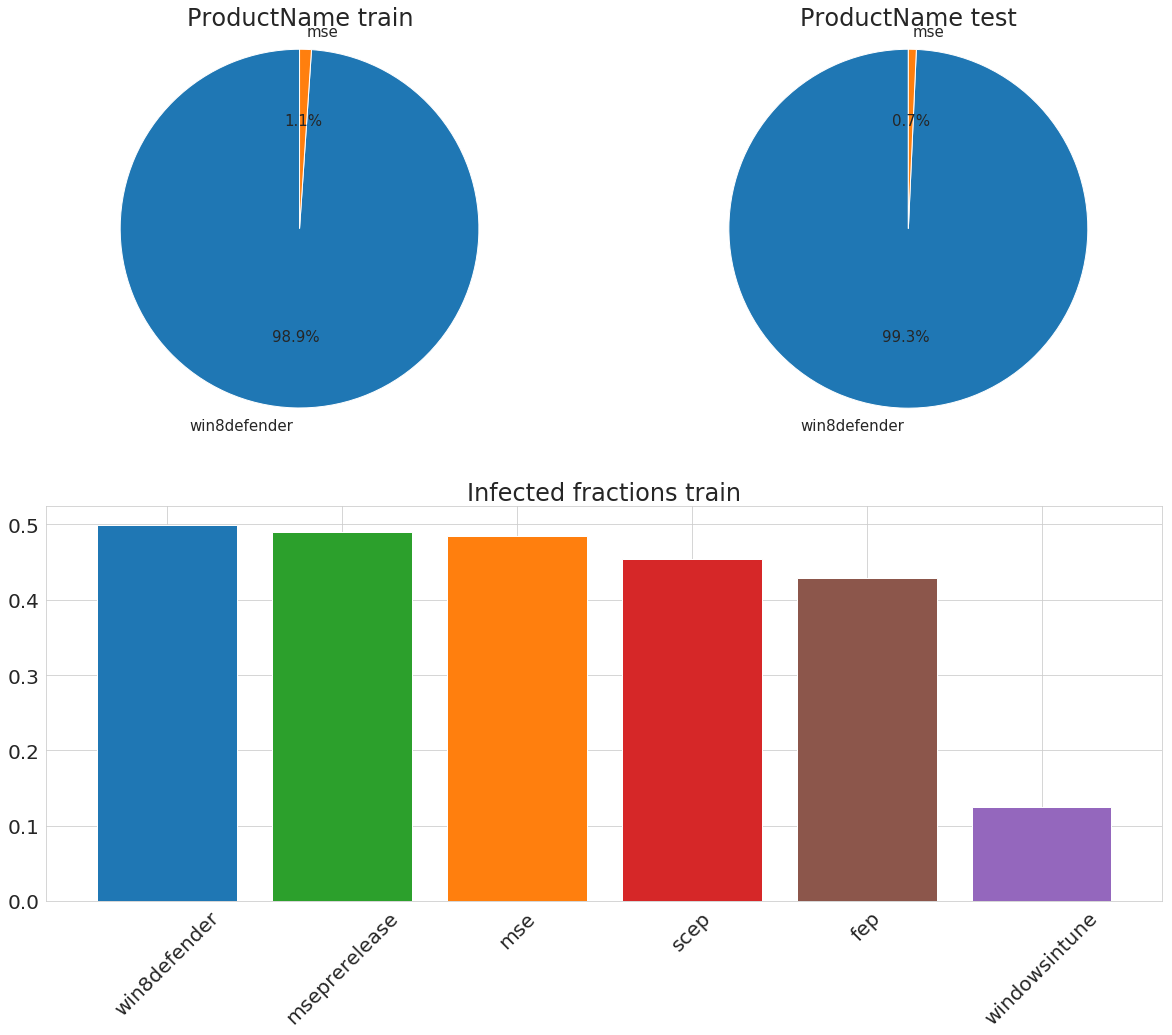

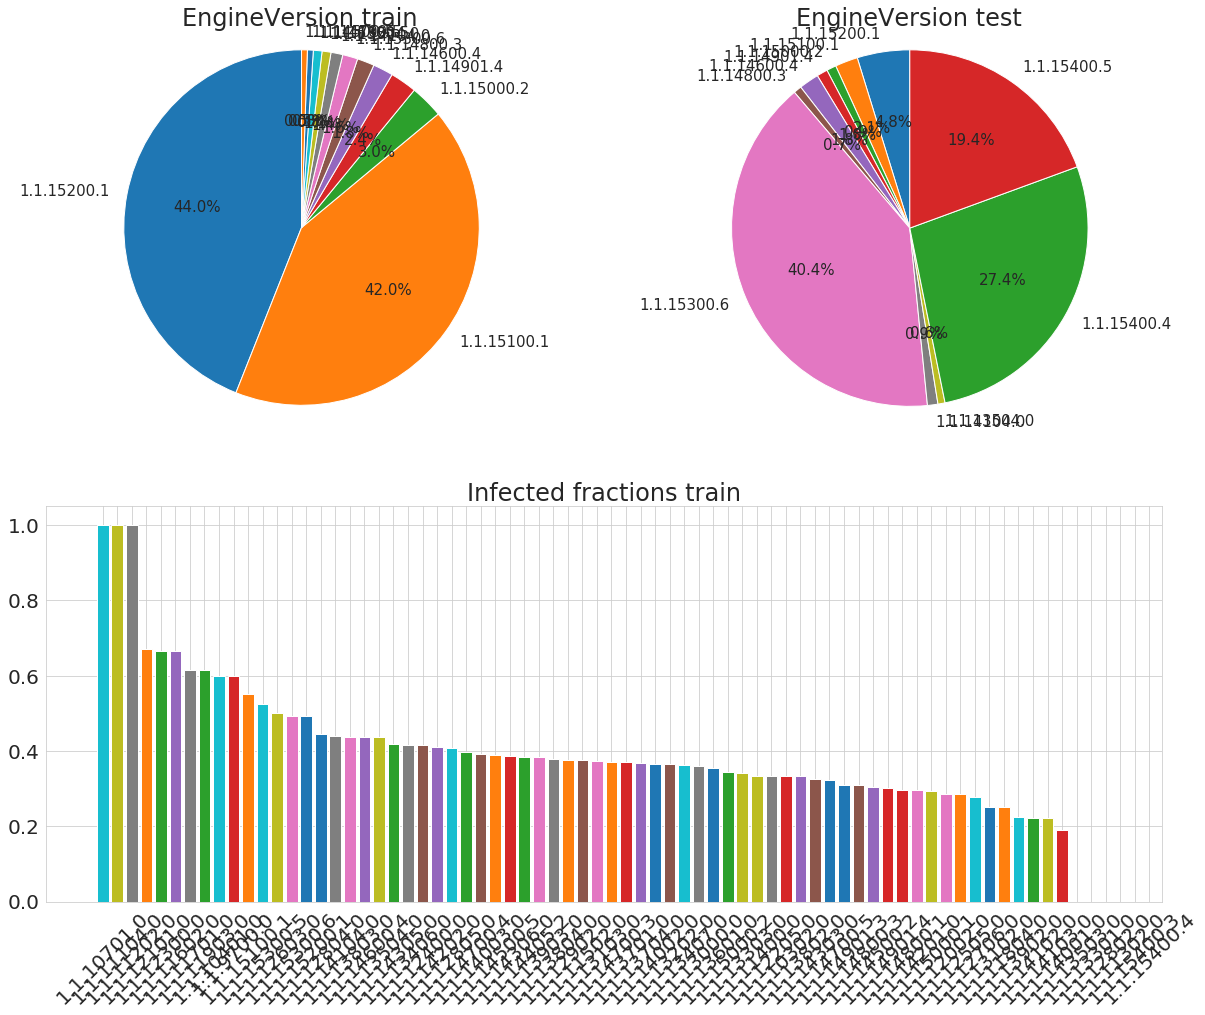

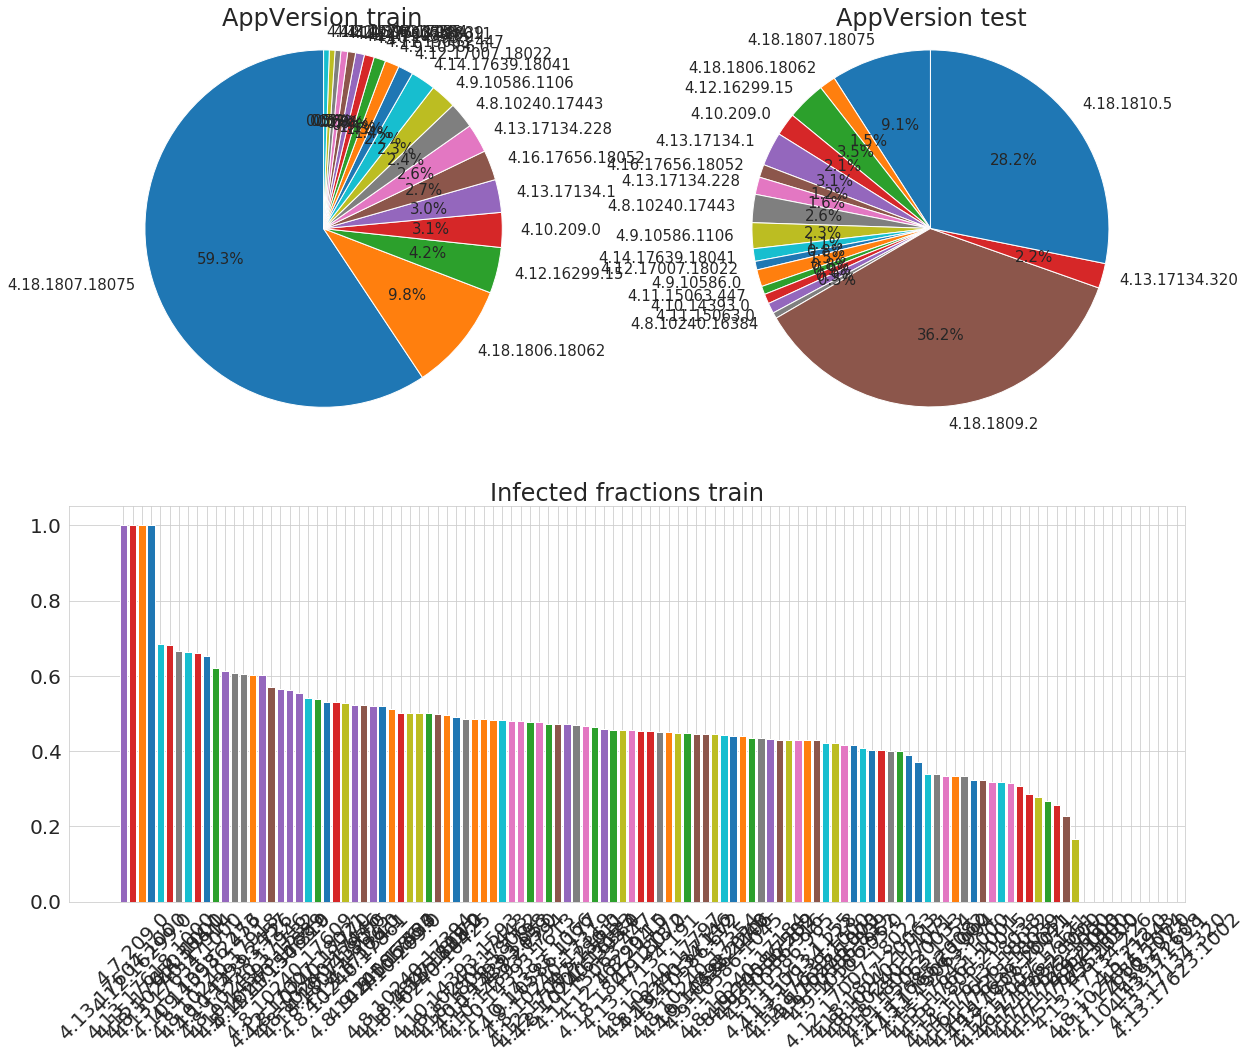

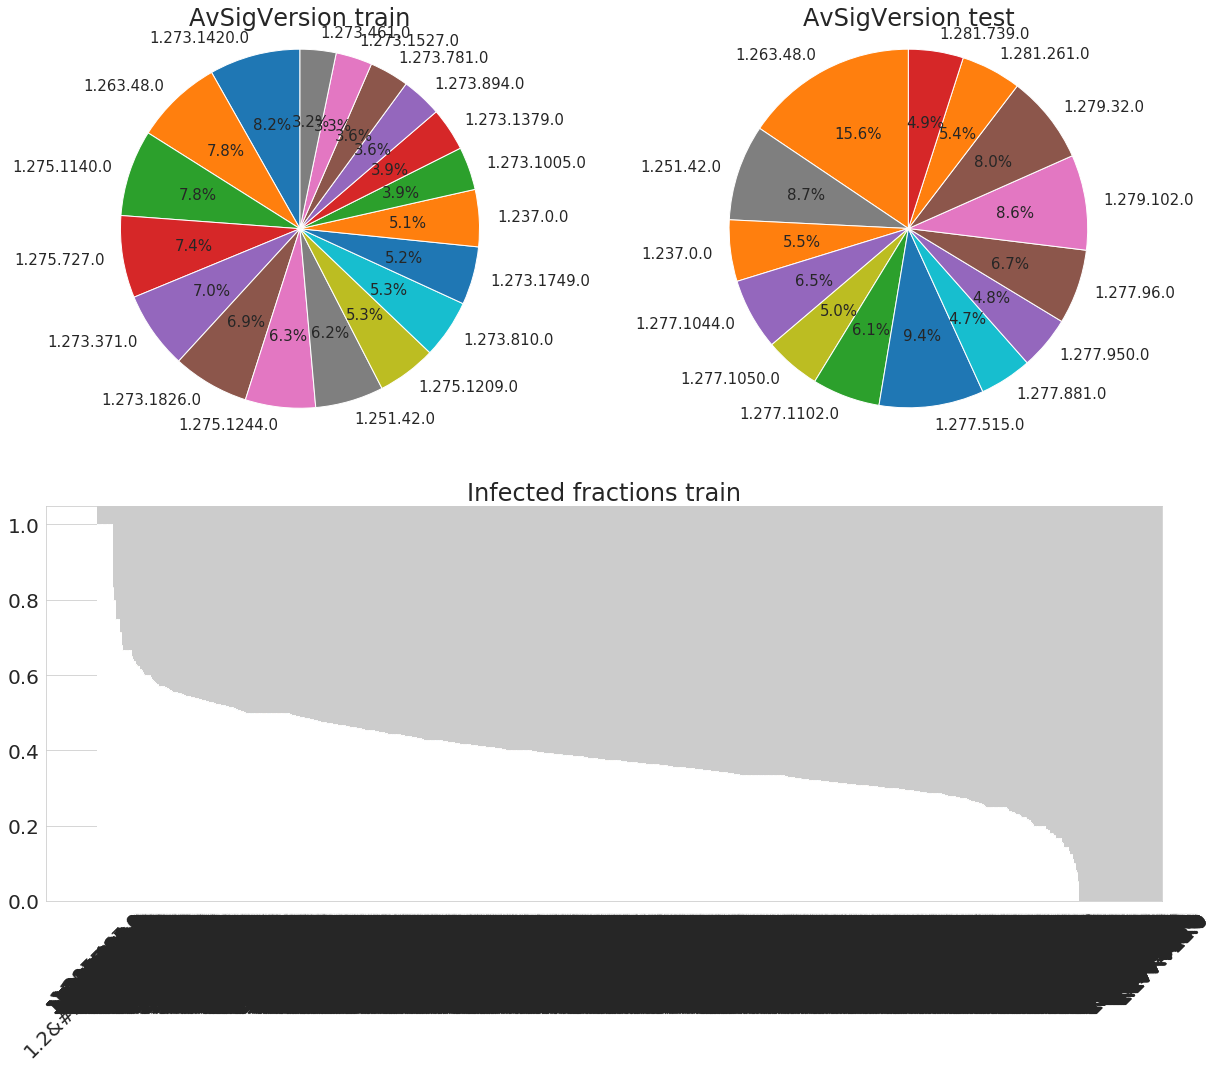

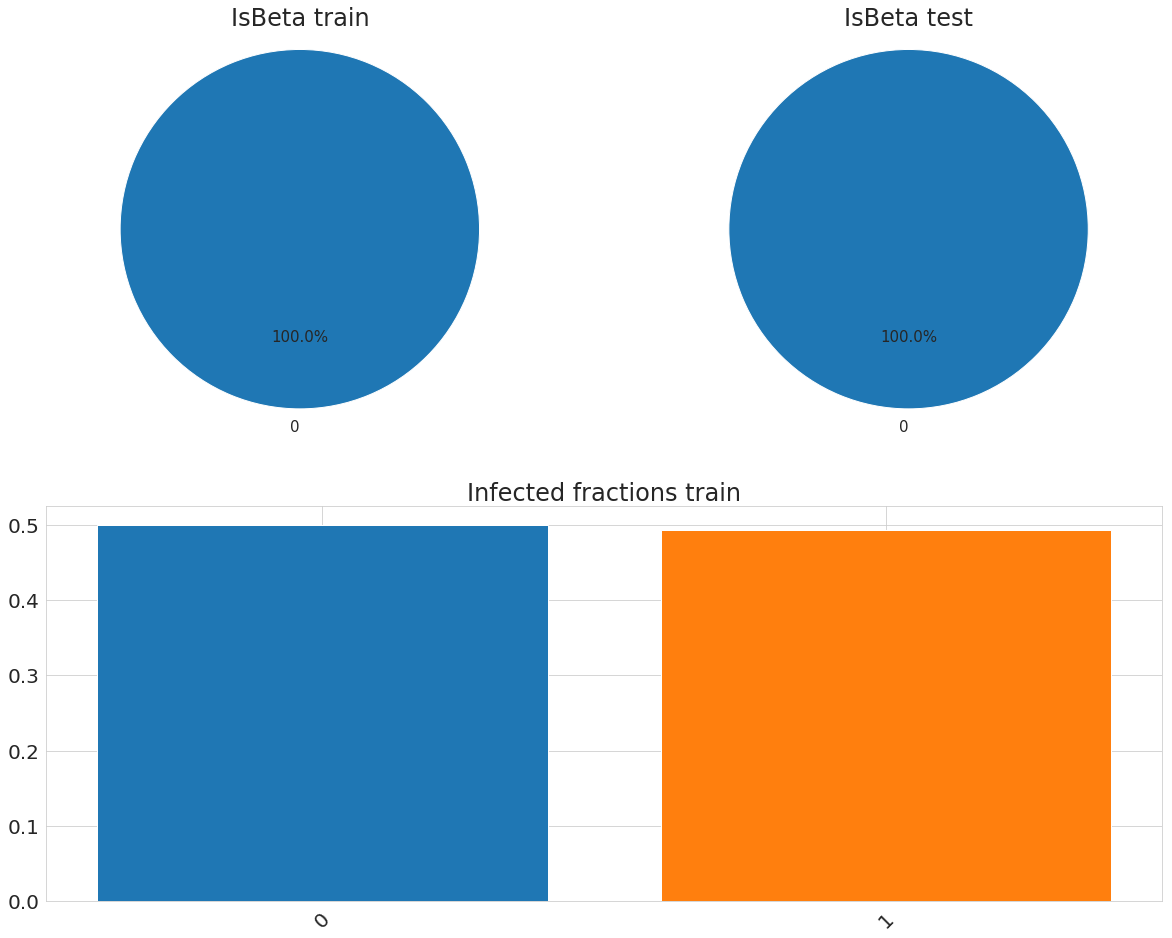

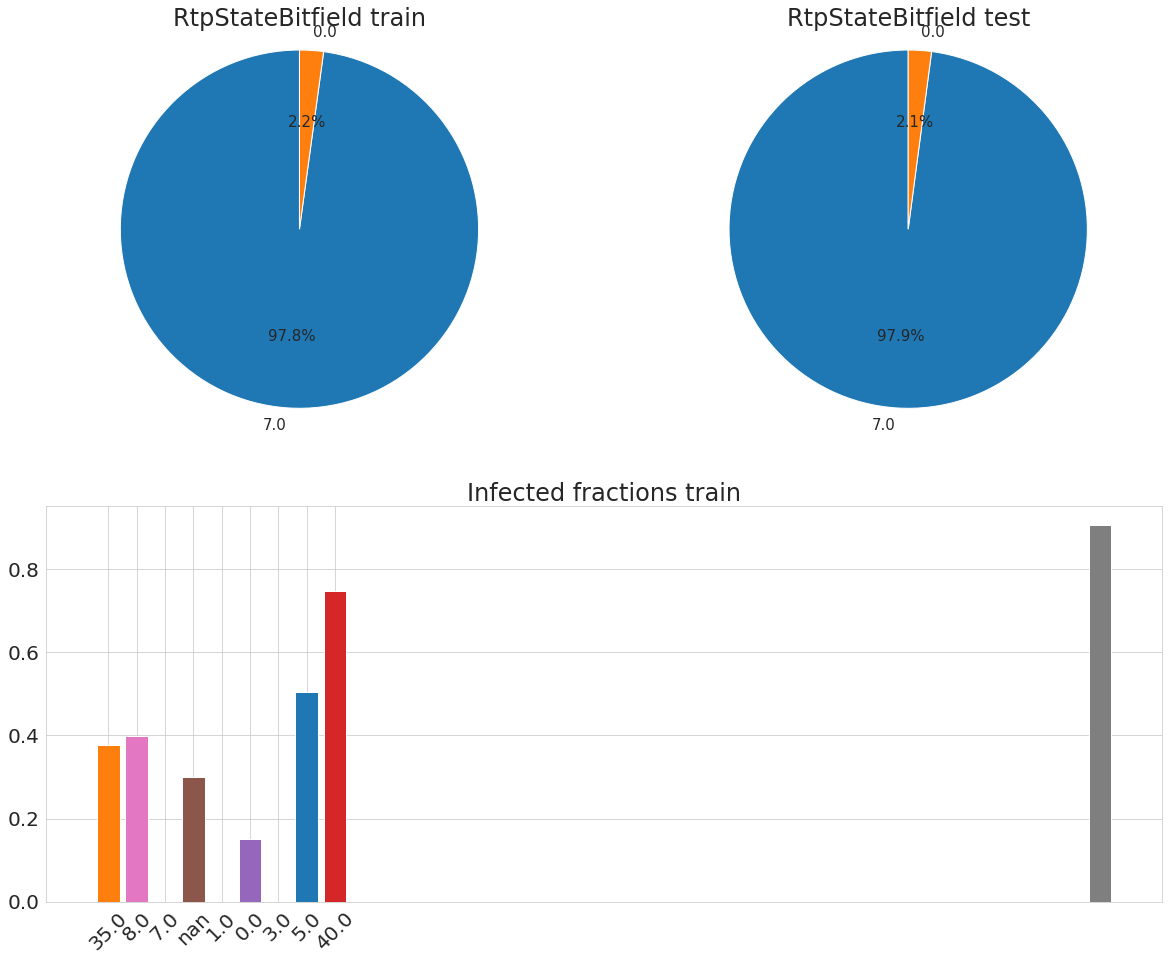

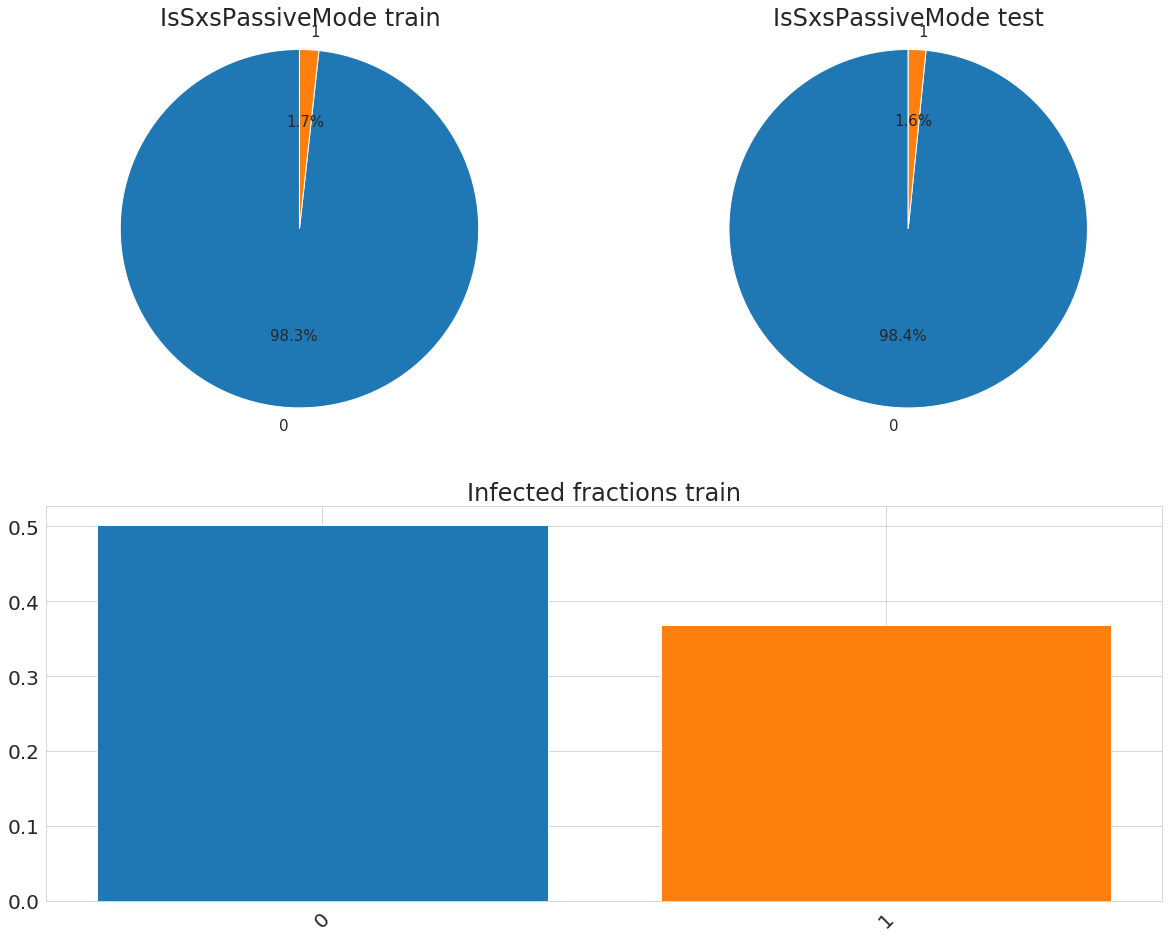

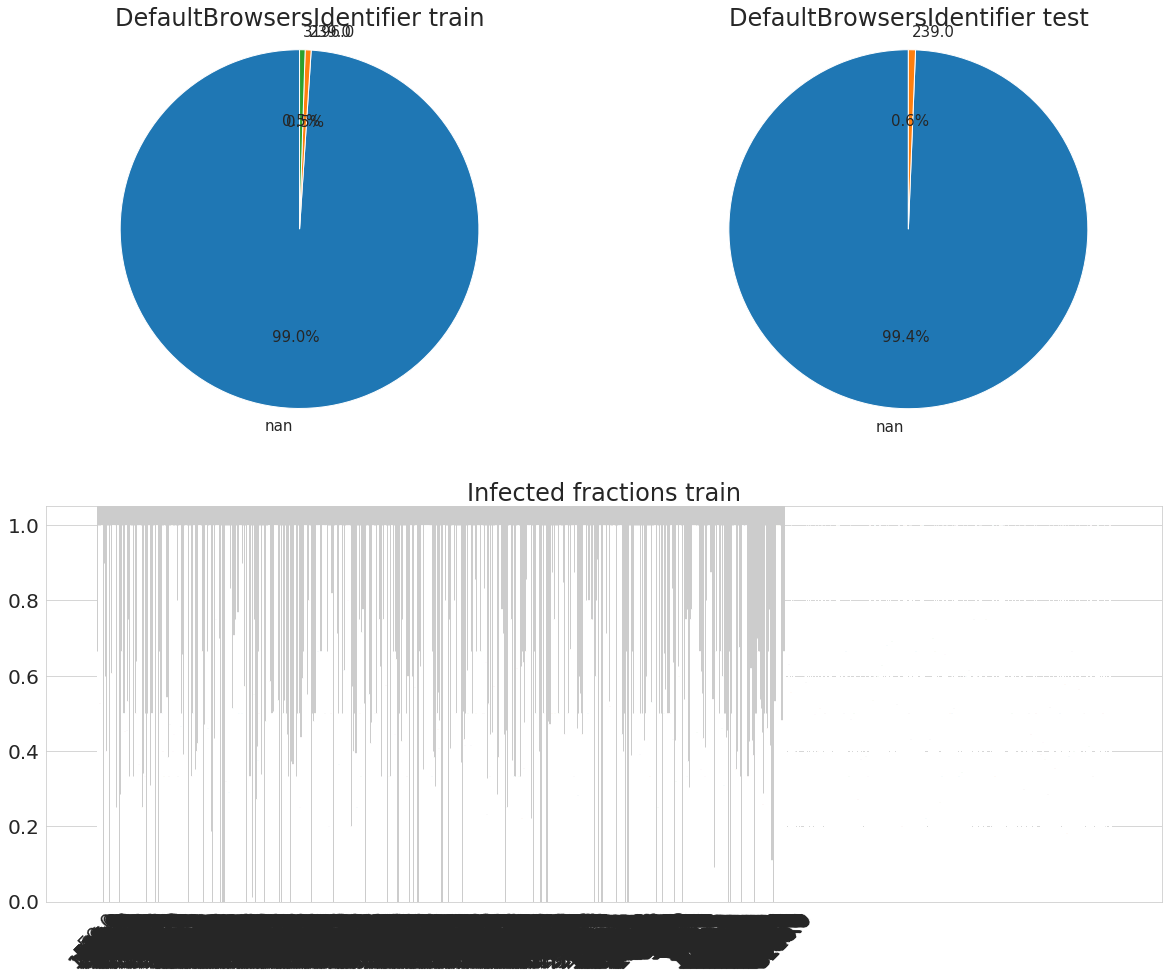

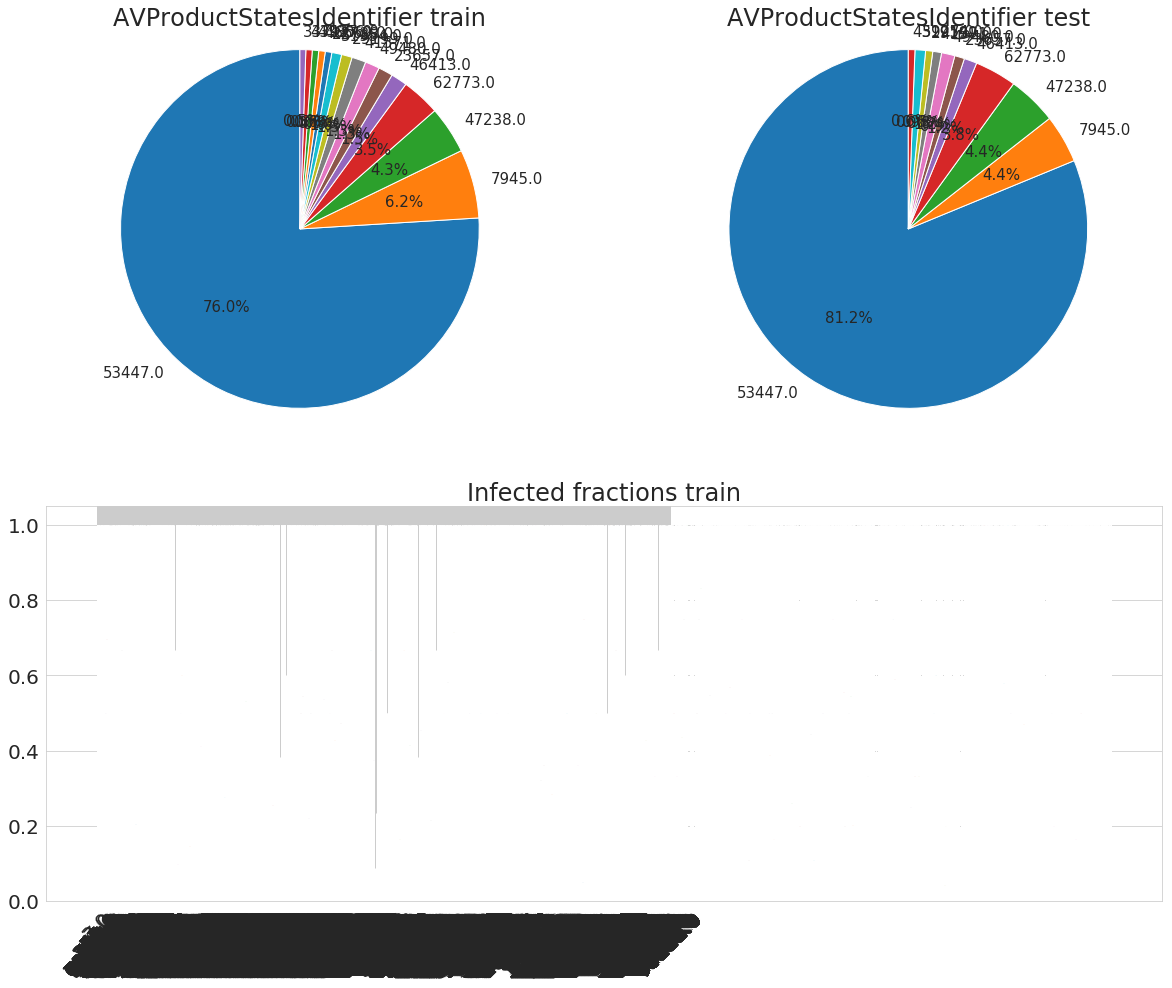

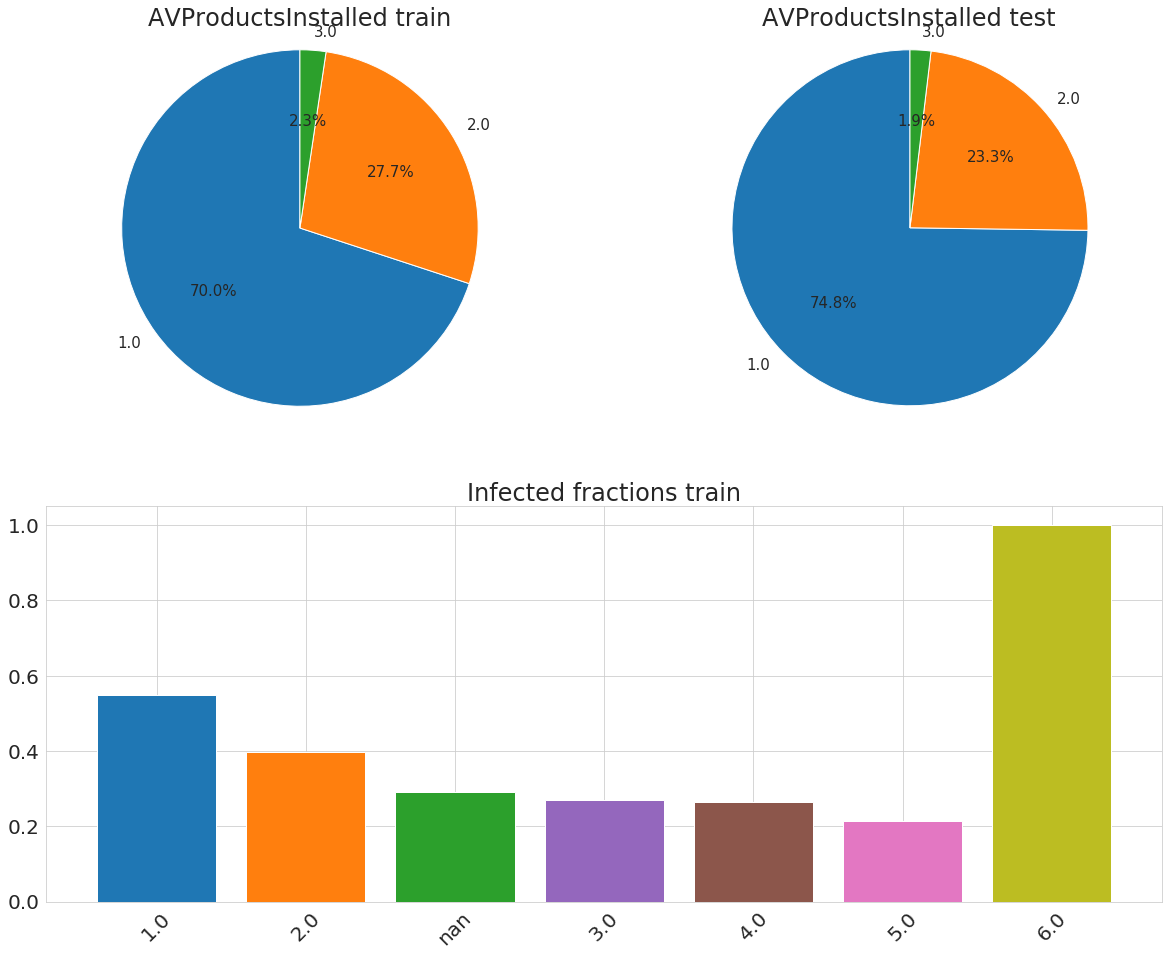

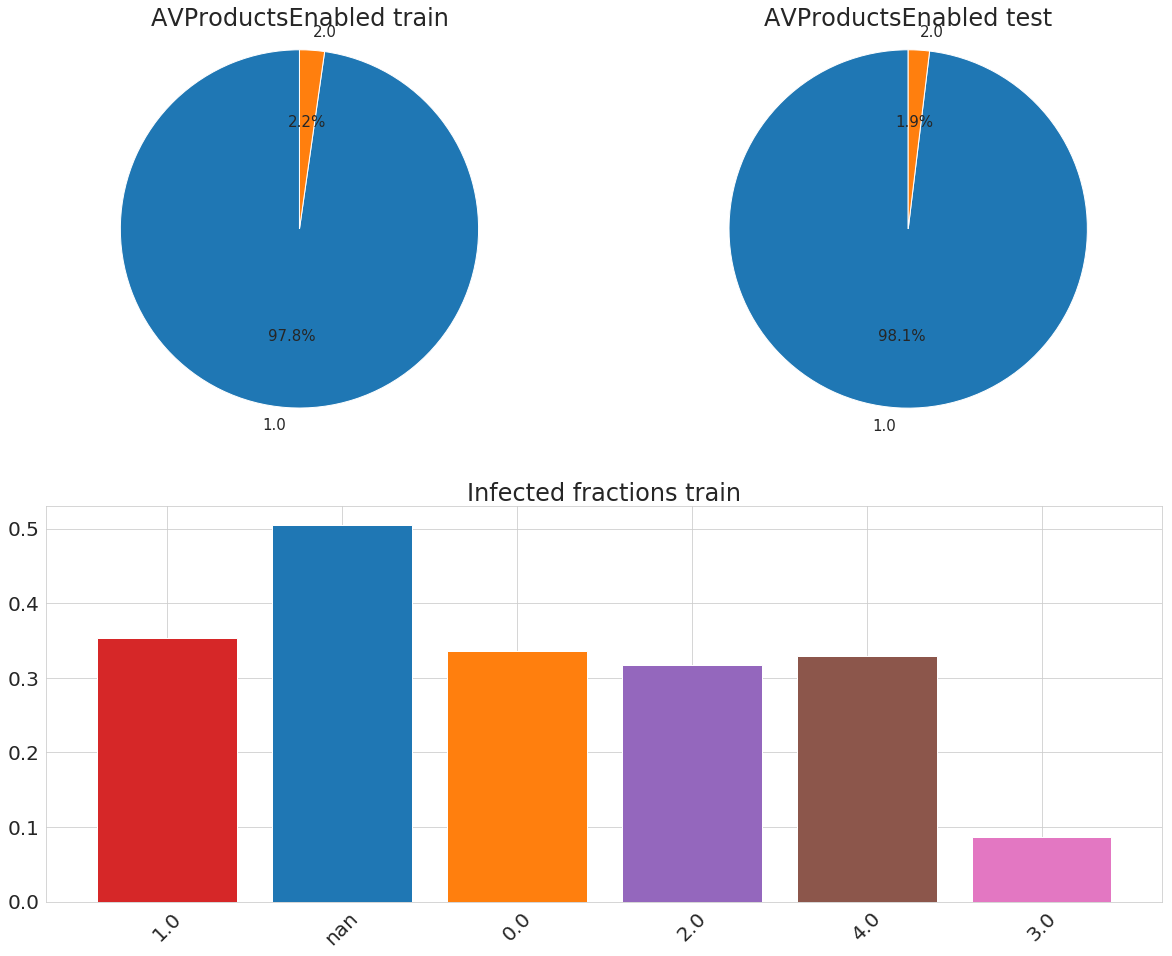

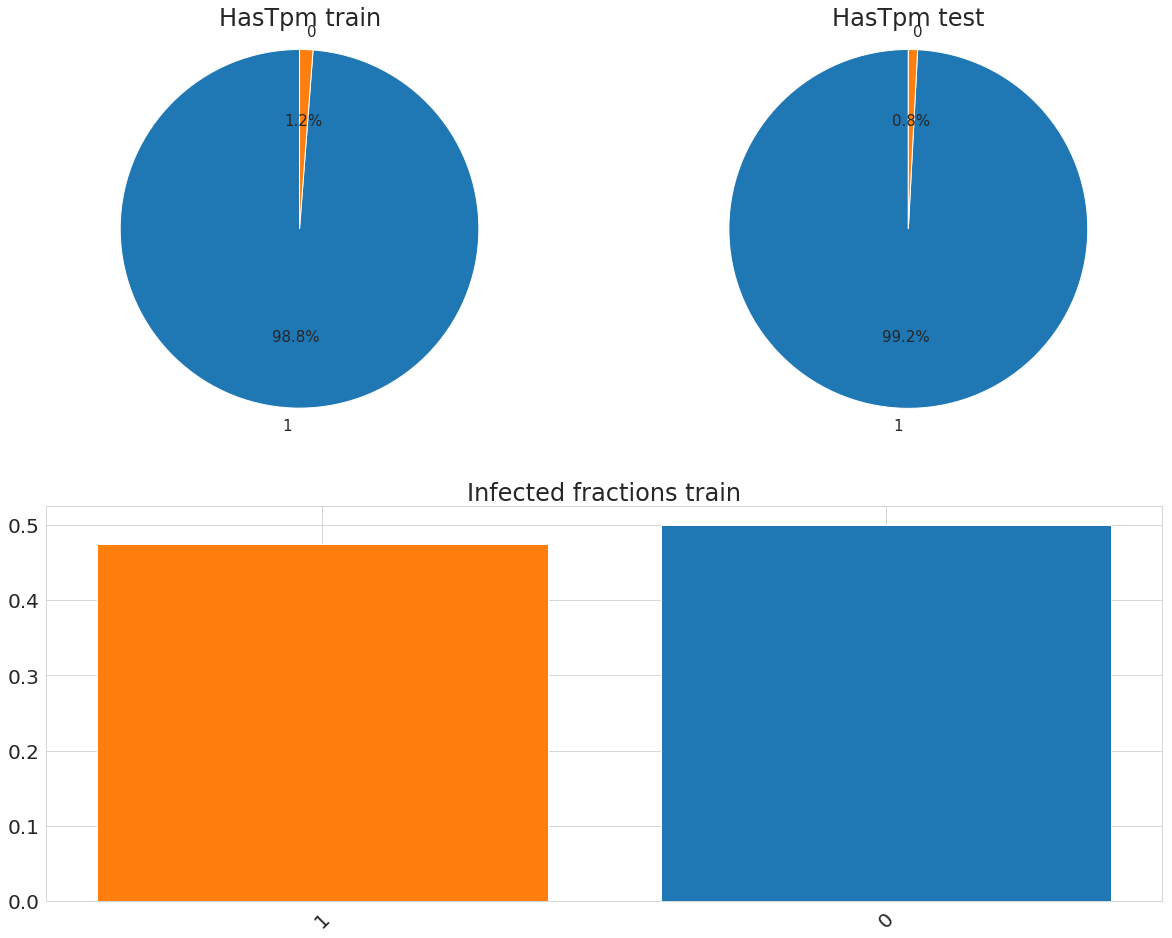

In [14]:
for col in feature[1:13]:
    my_graphs1(col)

#### Location関連

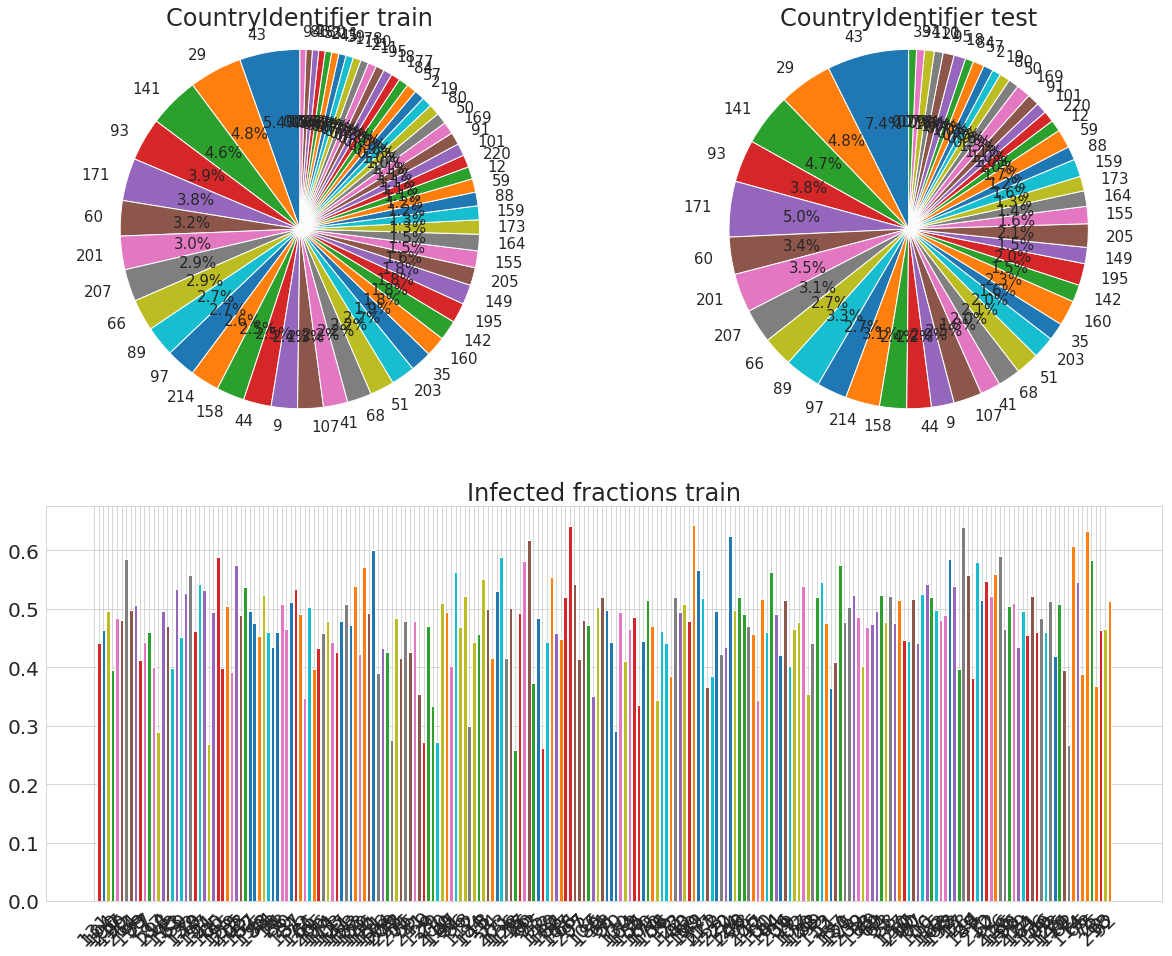

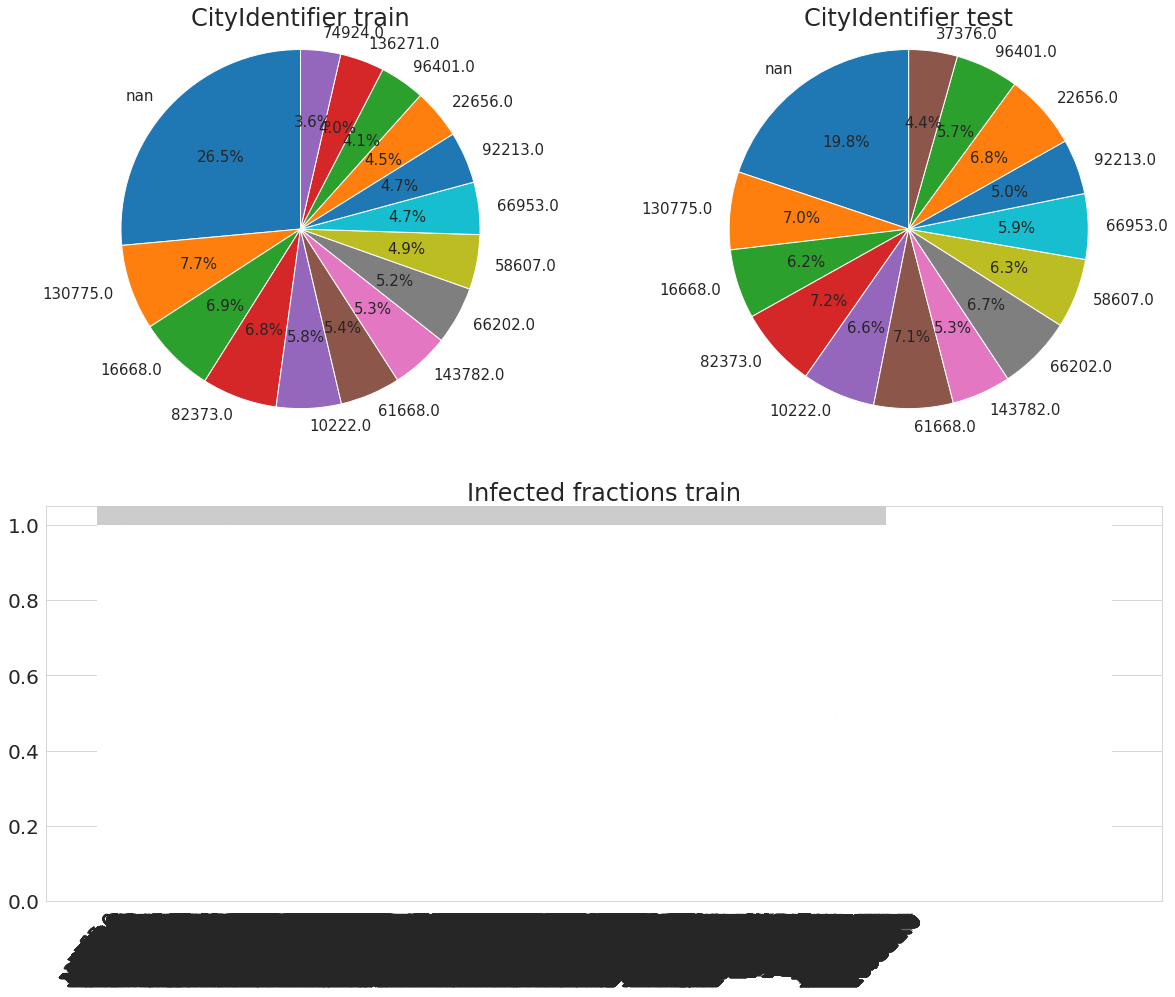

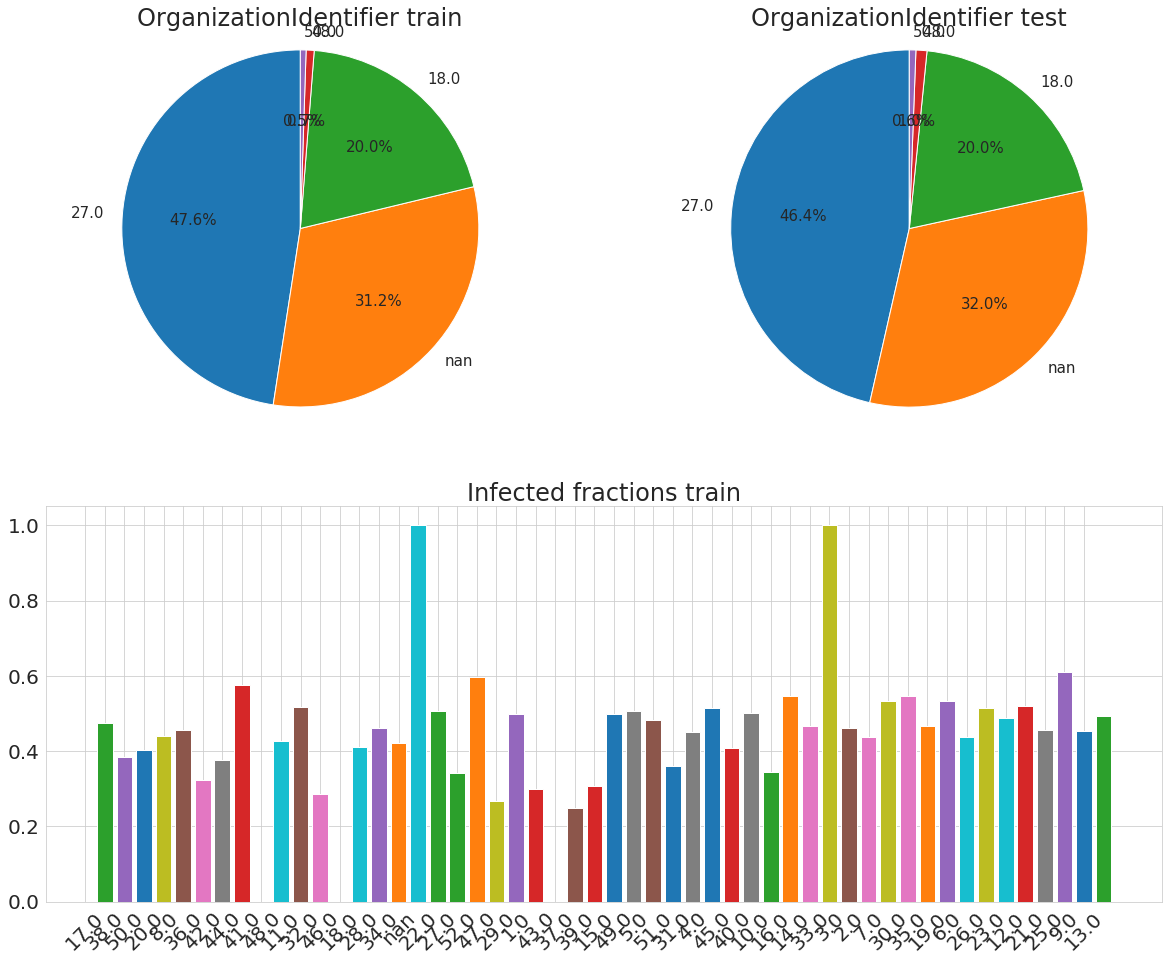

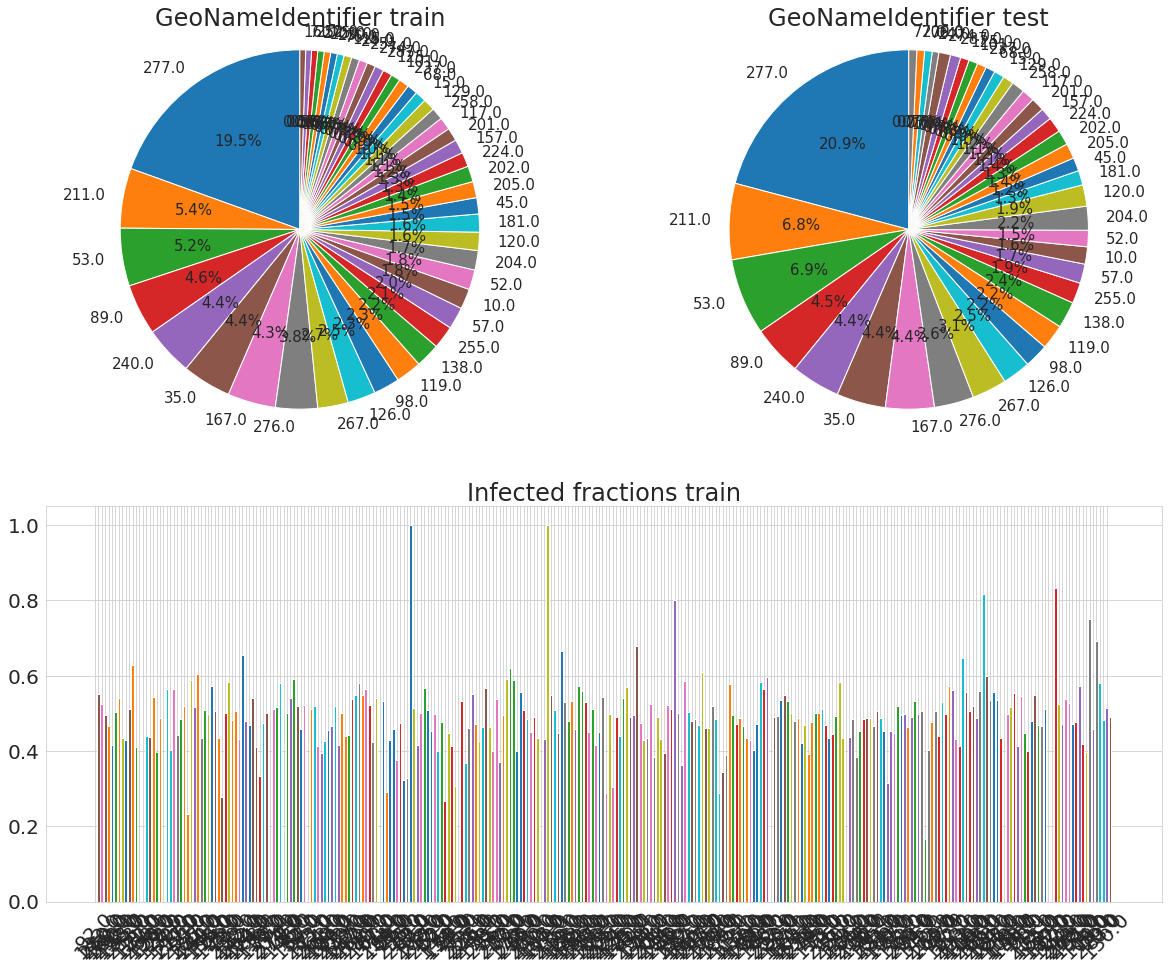

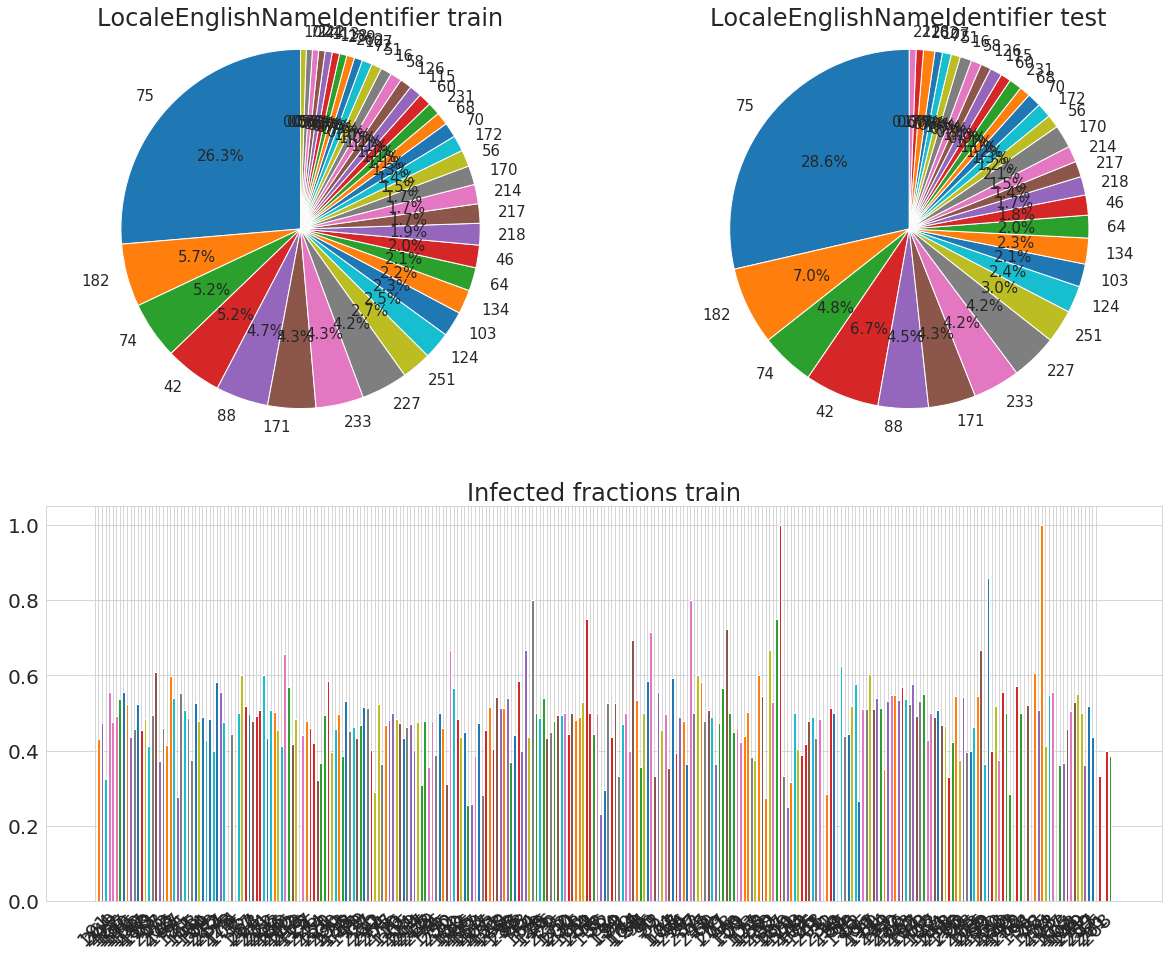

In [15]:
for col in feature[13:18]:
    my_graphs1(col)

#### OS関連

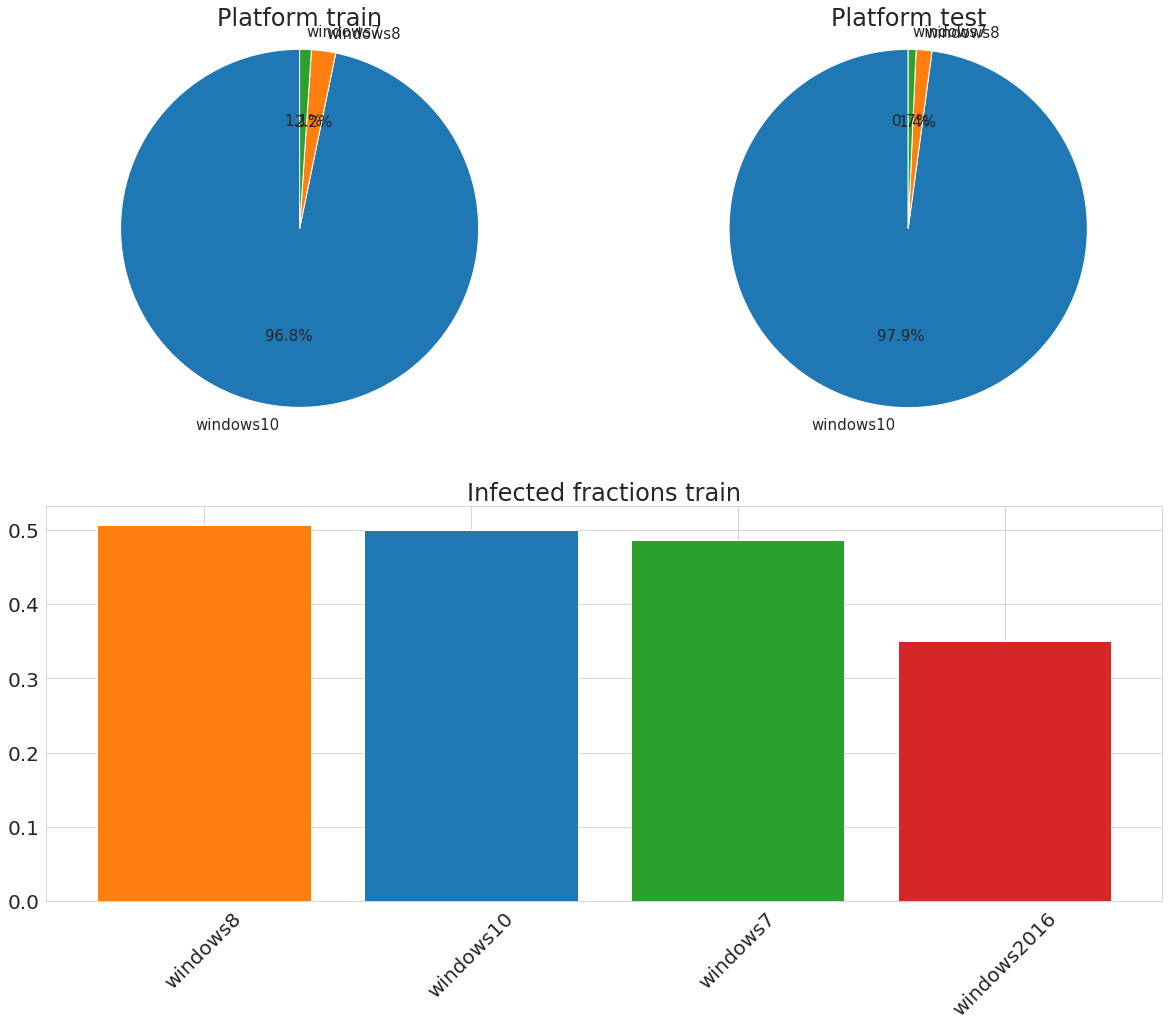

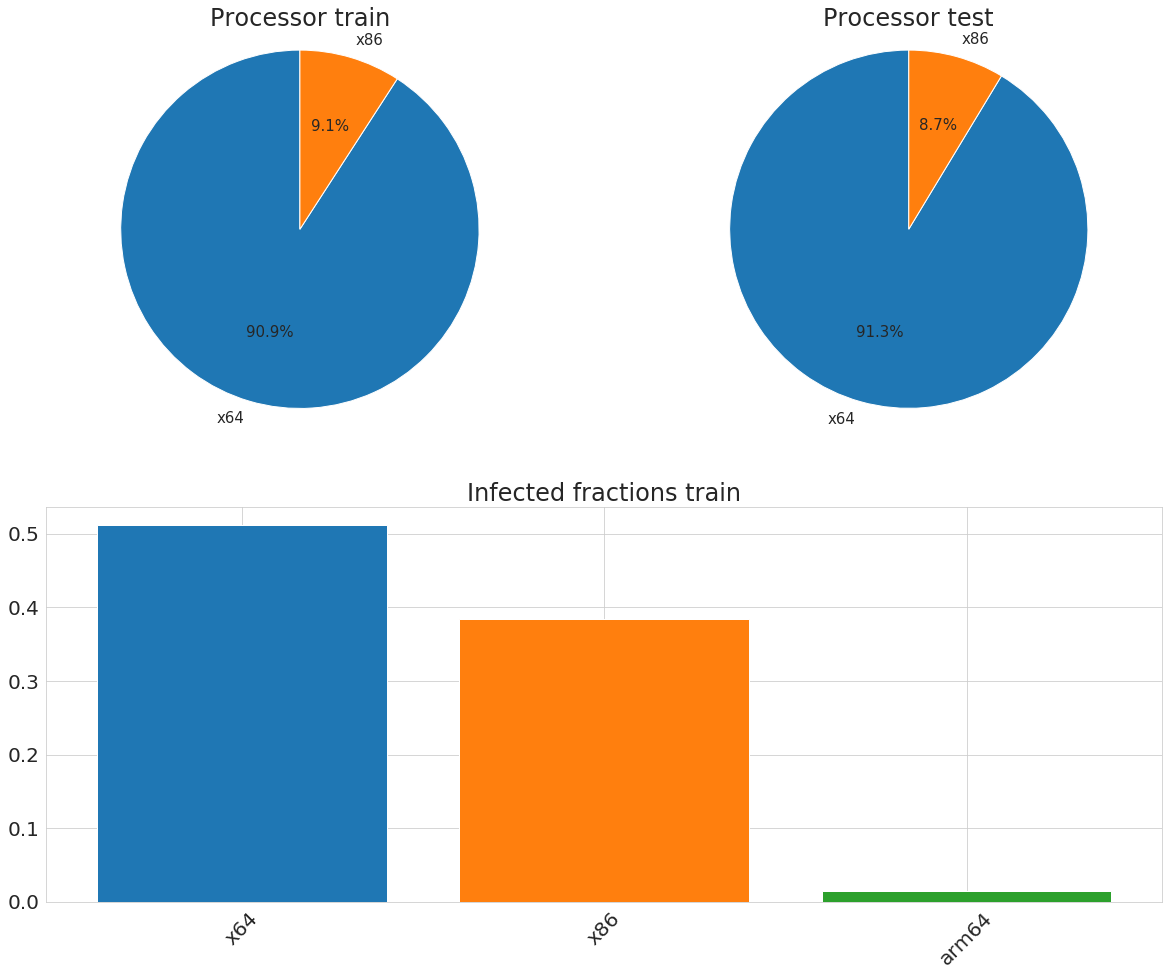

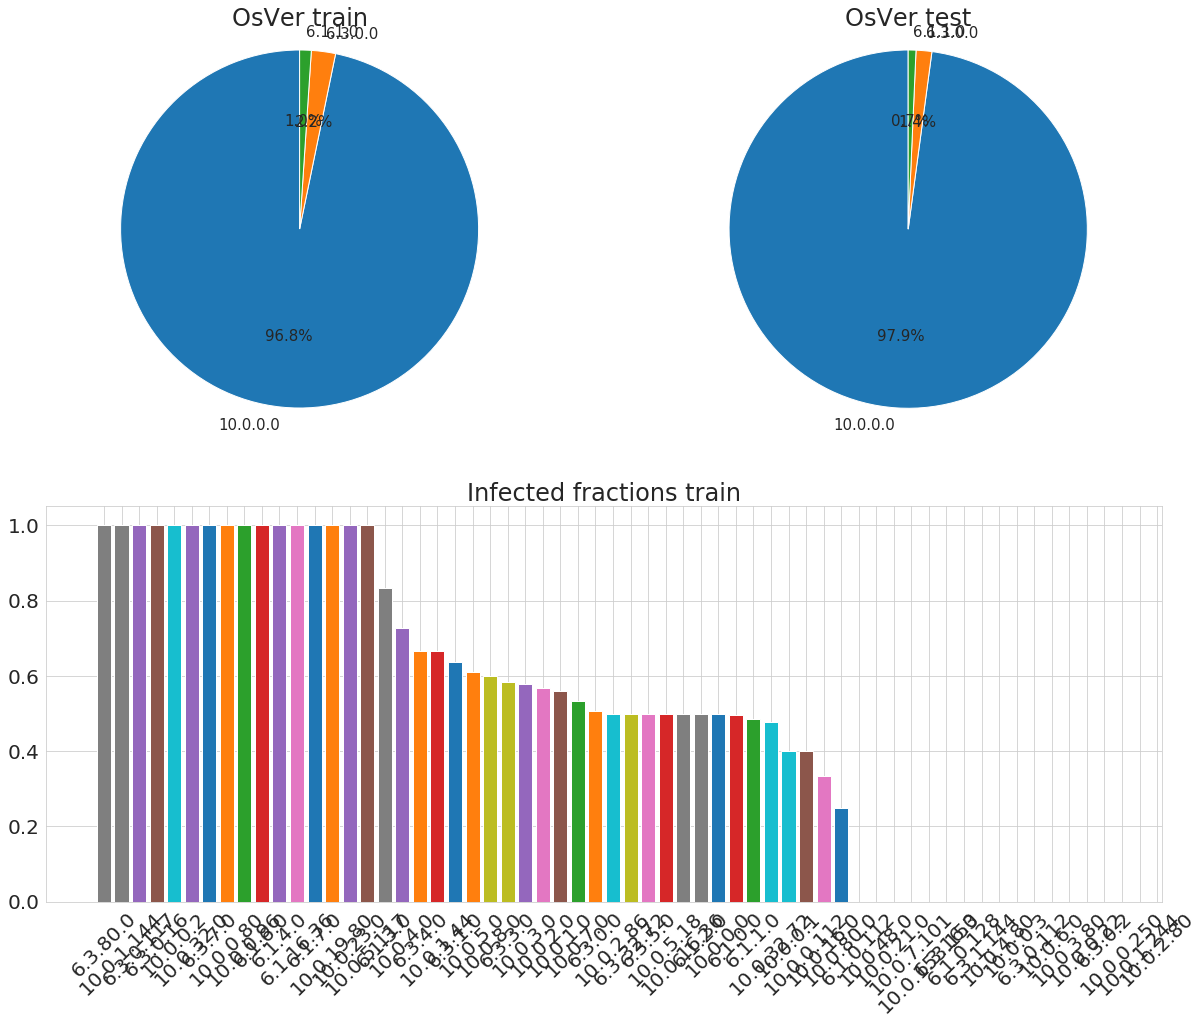

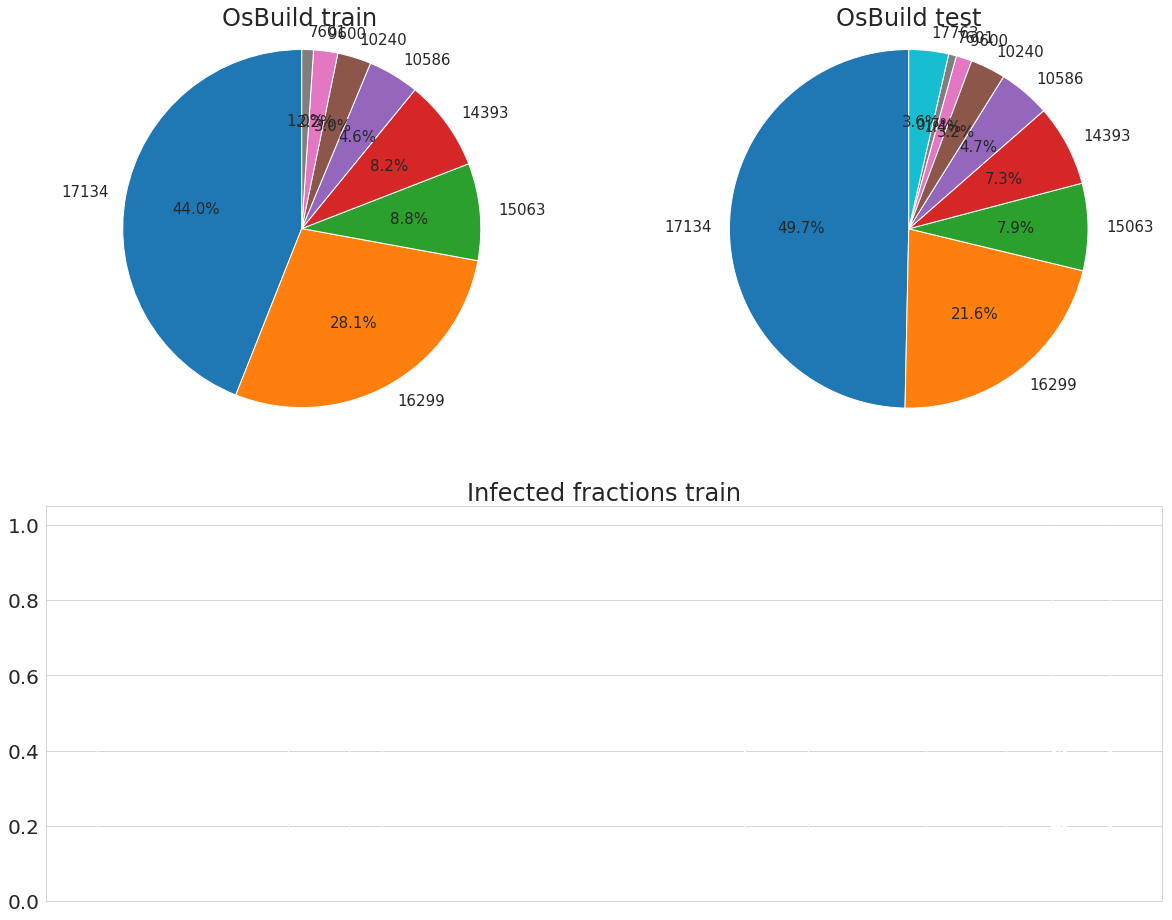

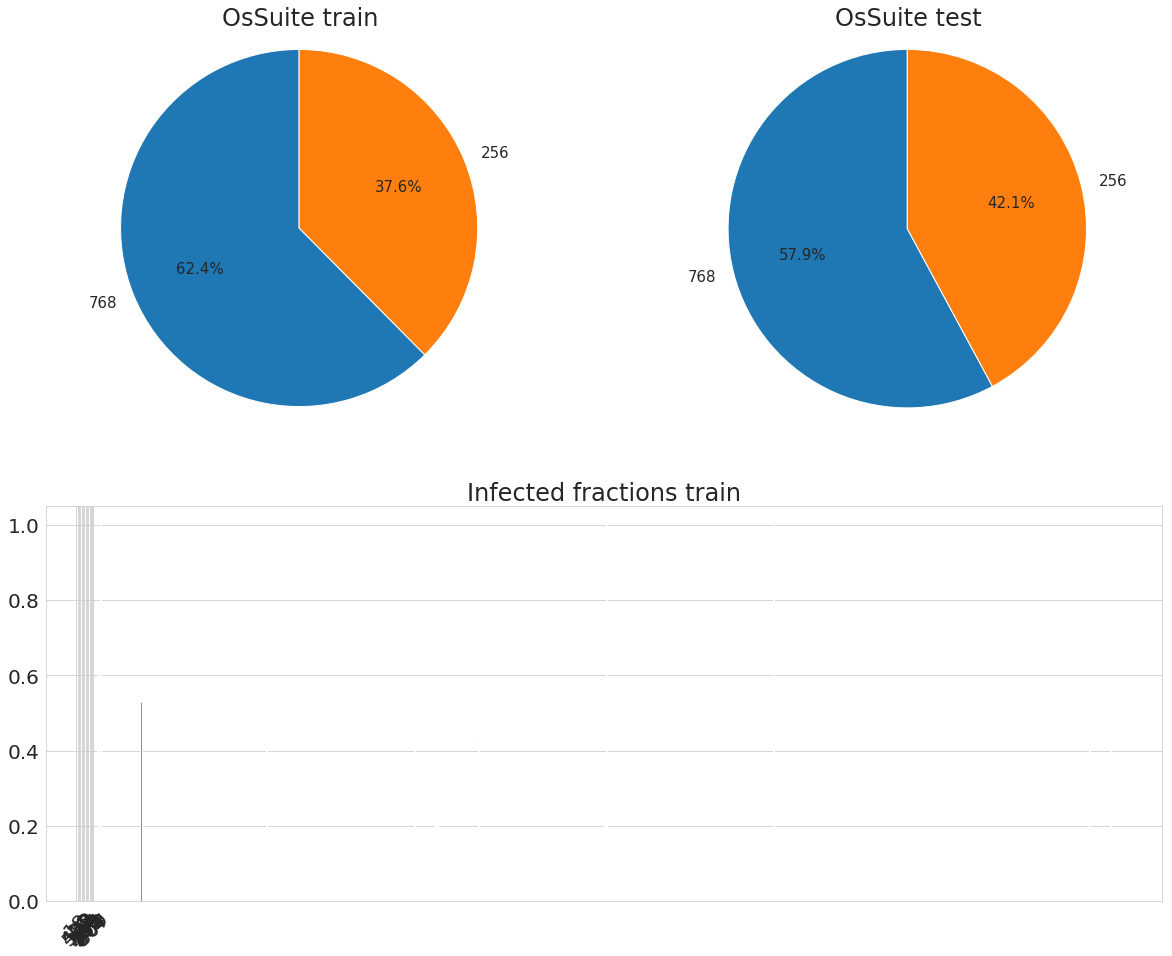

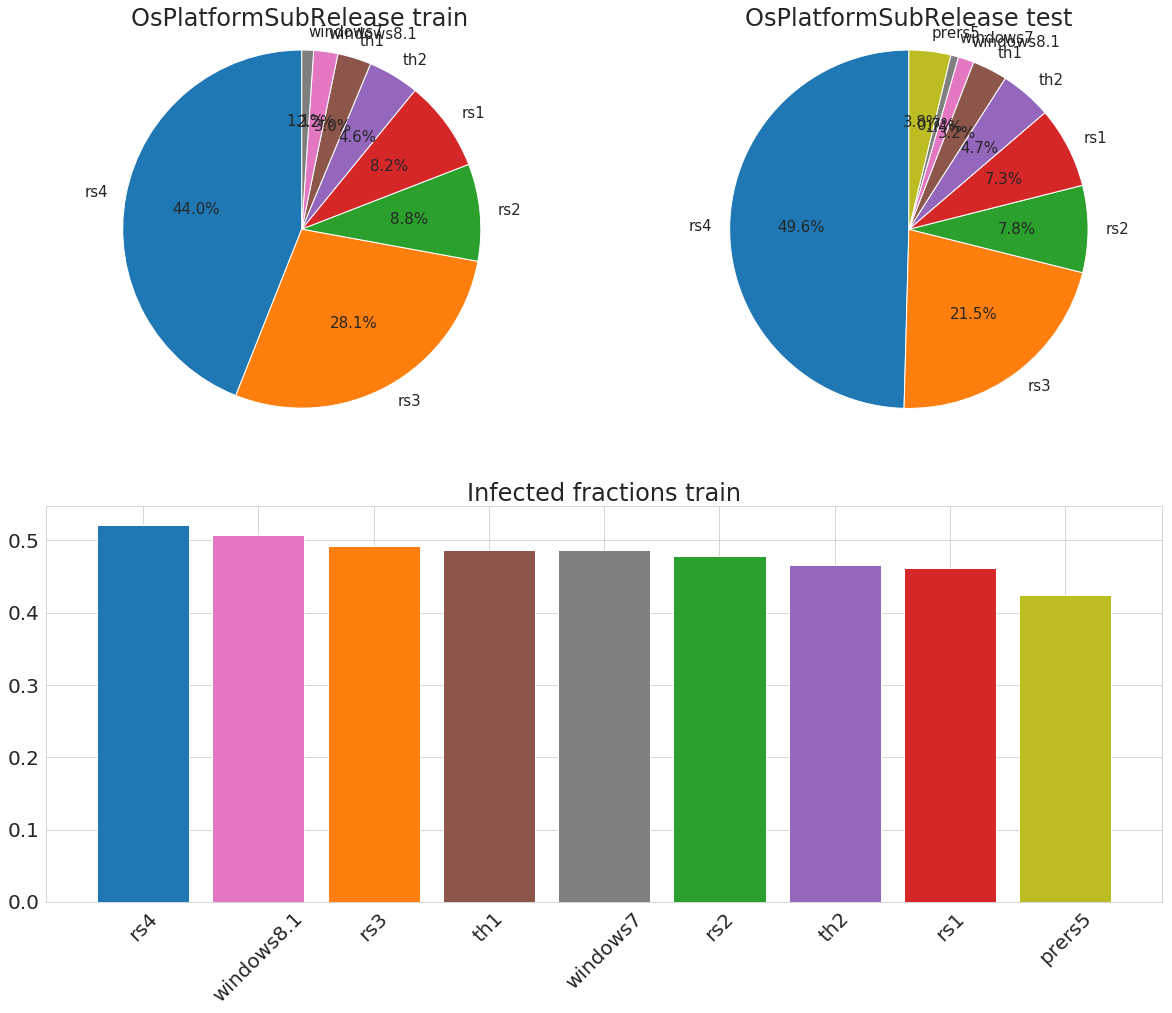

TypeError: nan is not a string

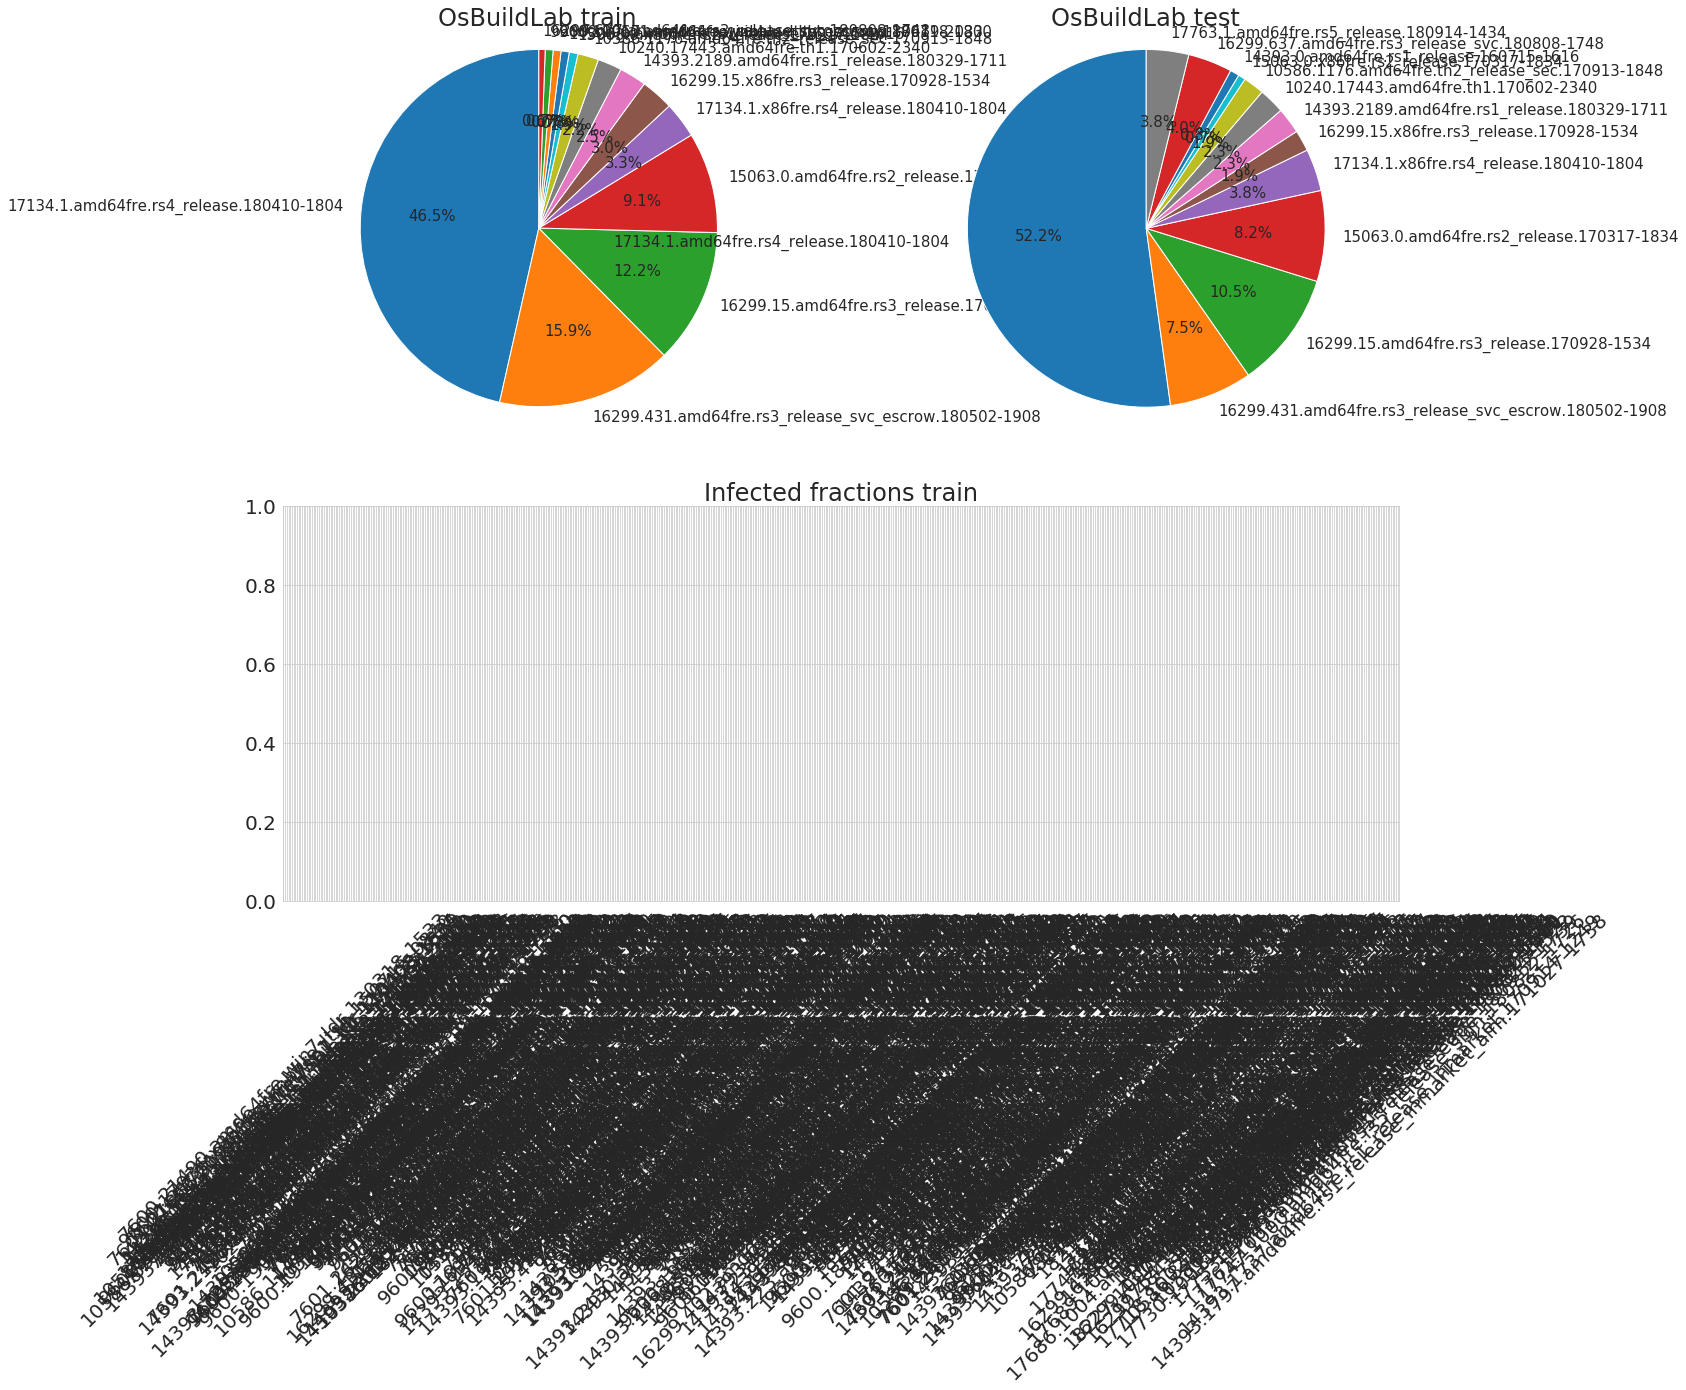

In [16]:
for col in feature[18:34]:
    my_graphs1(col)

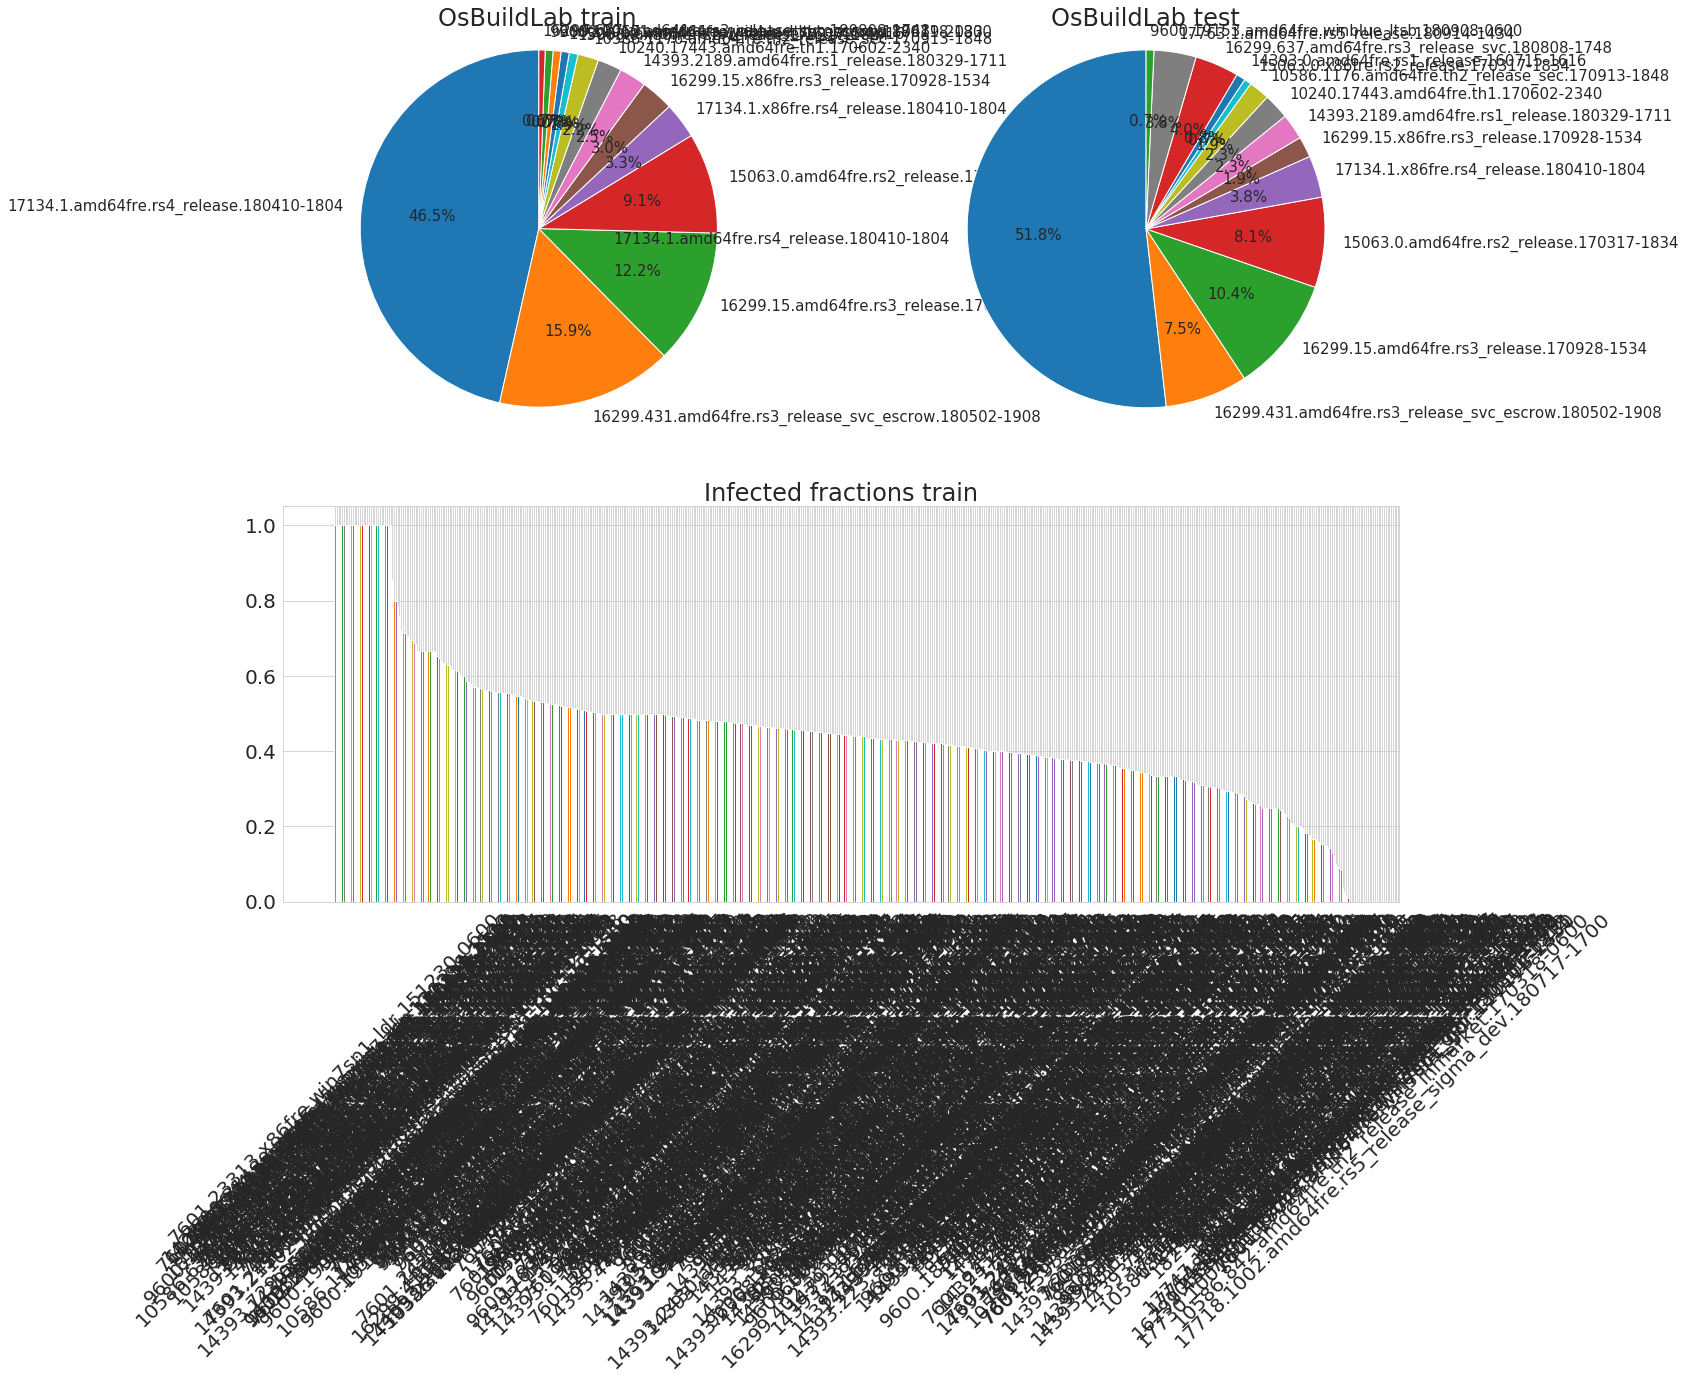

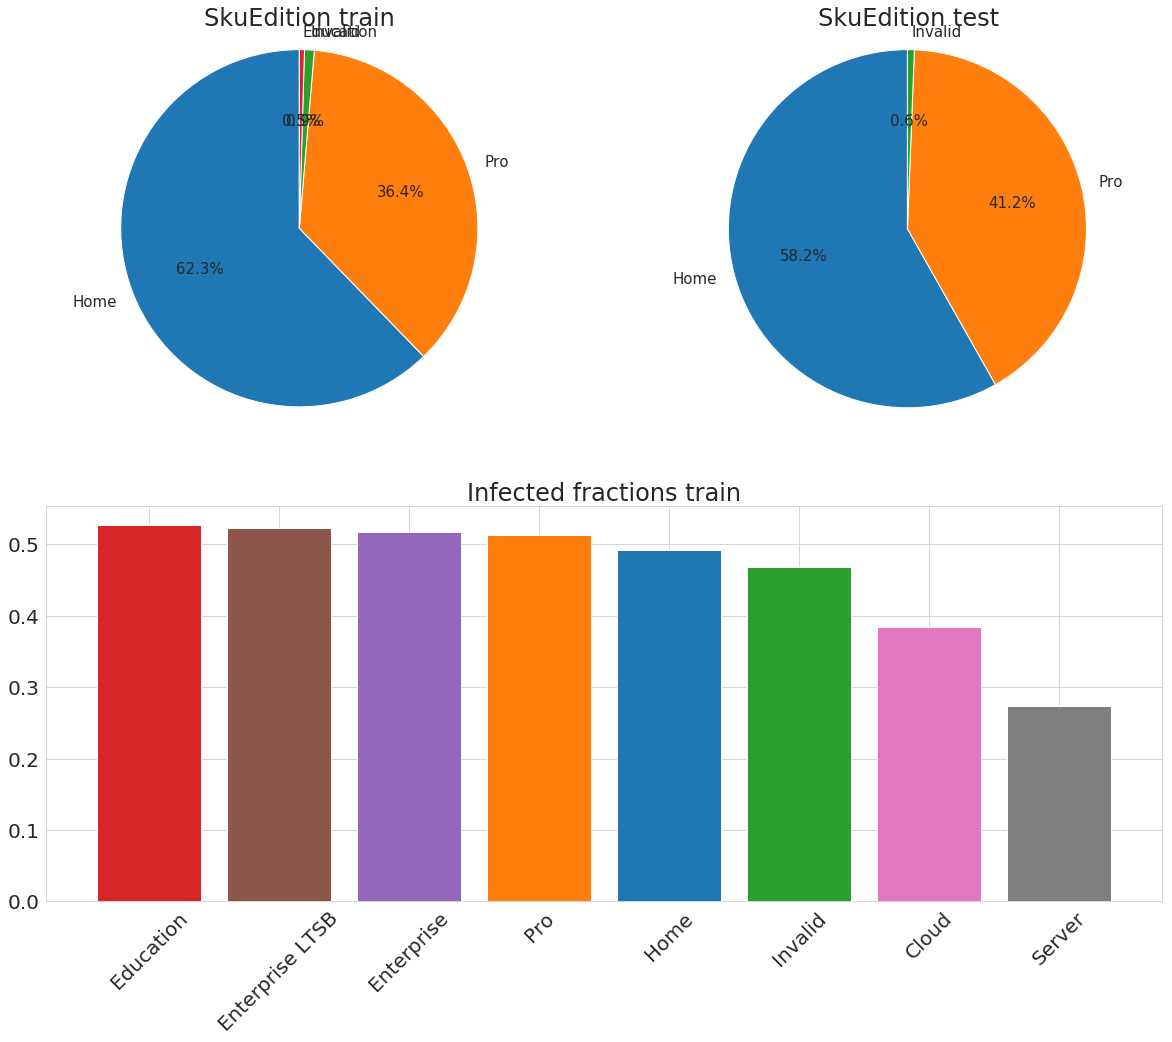

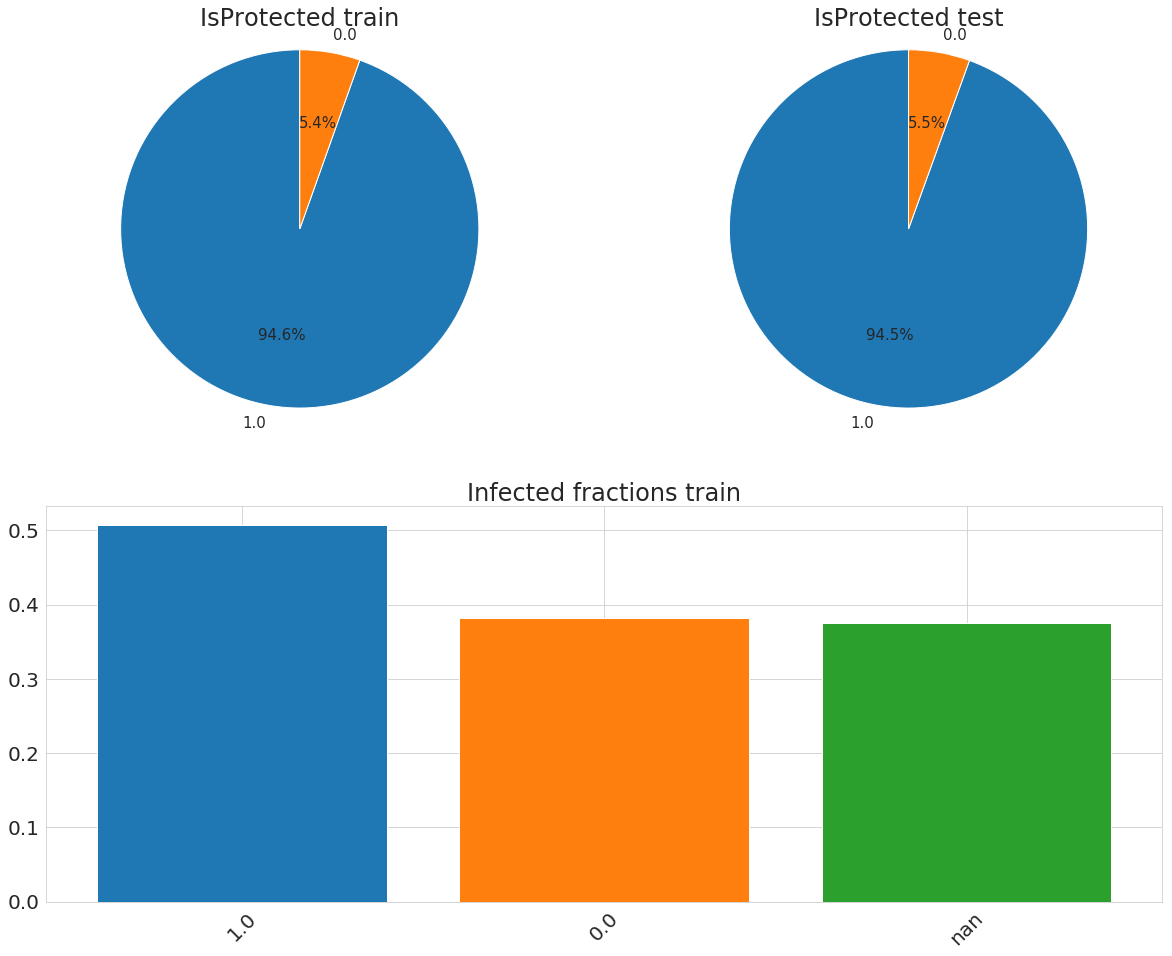

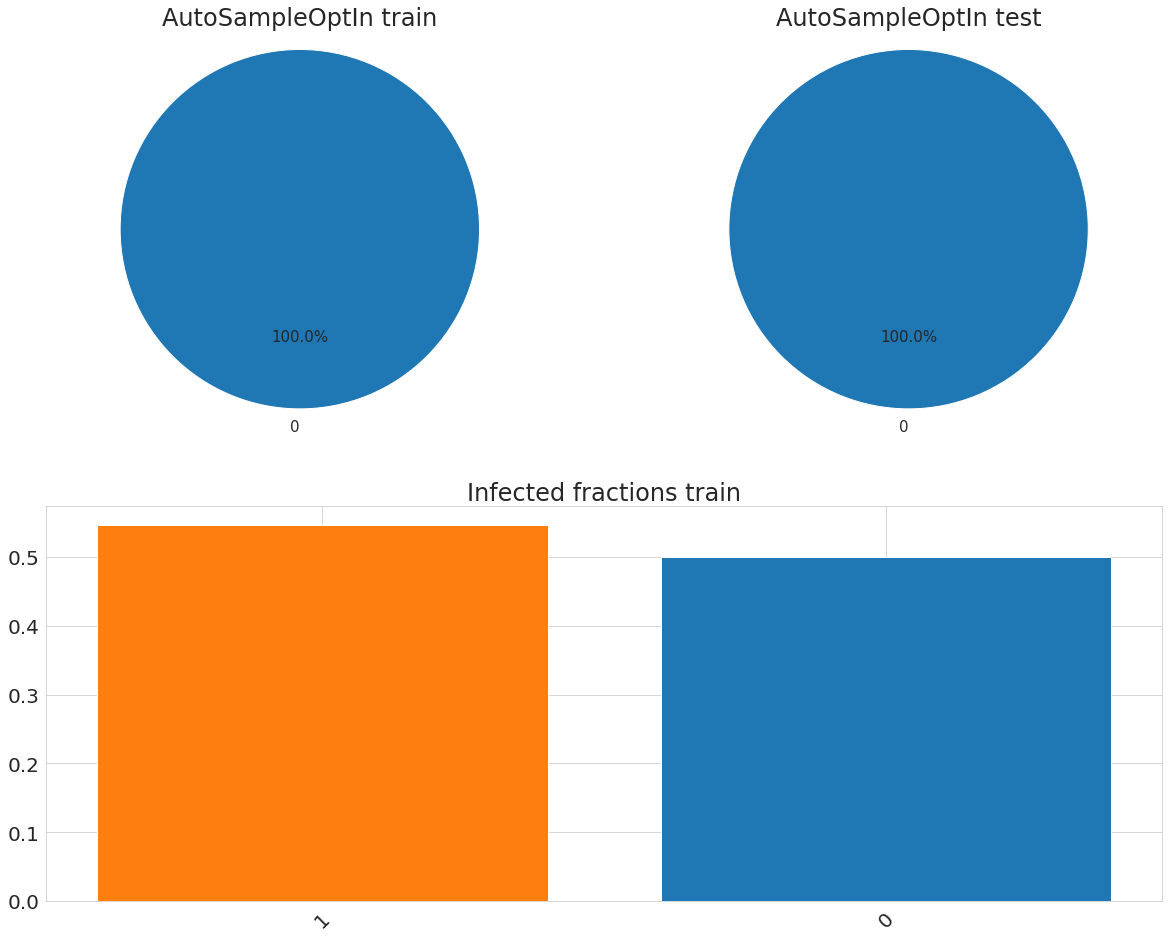

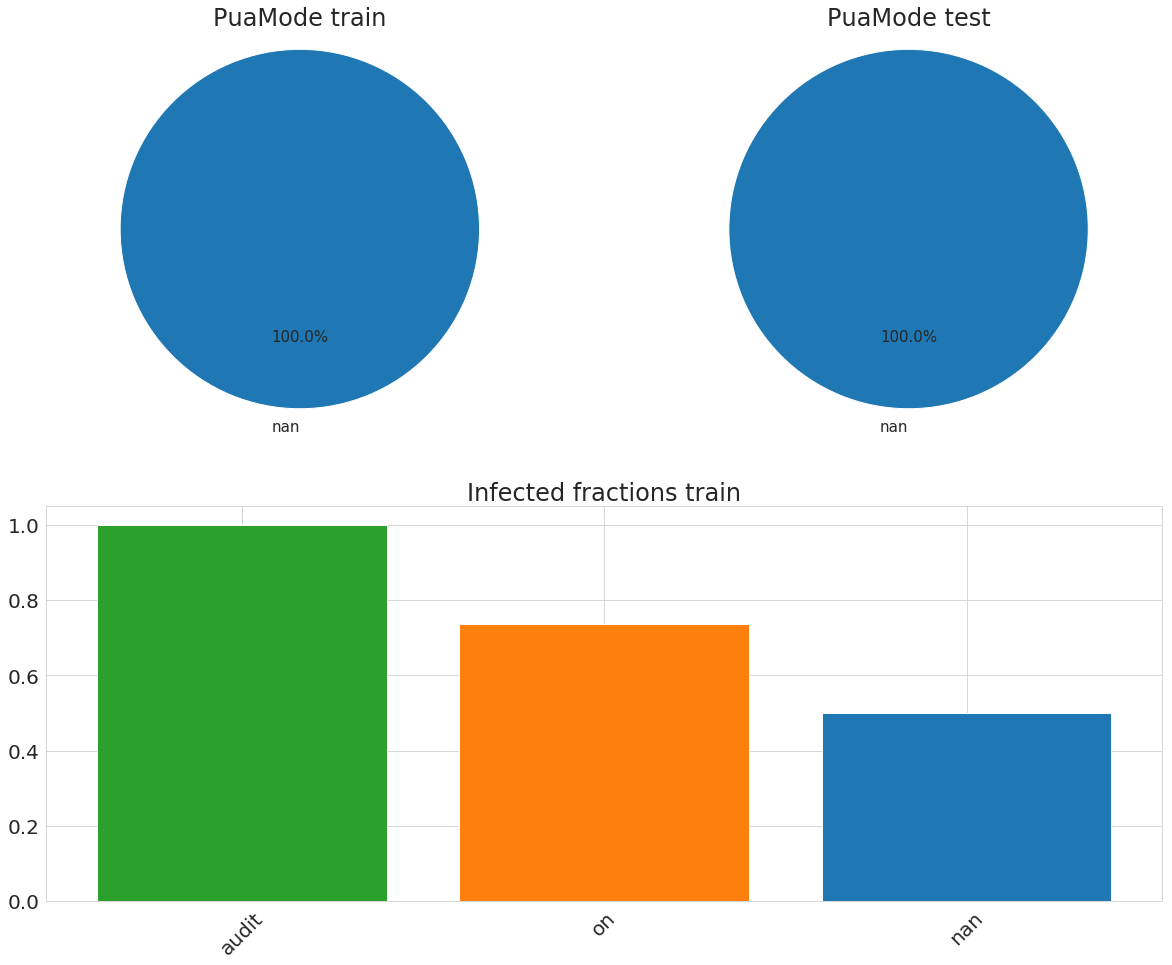

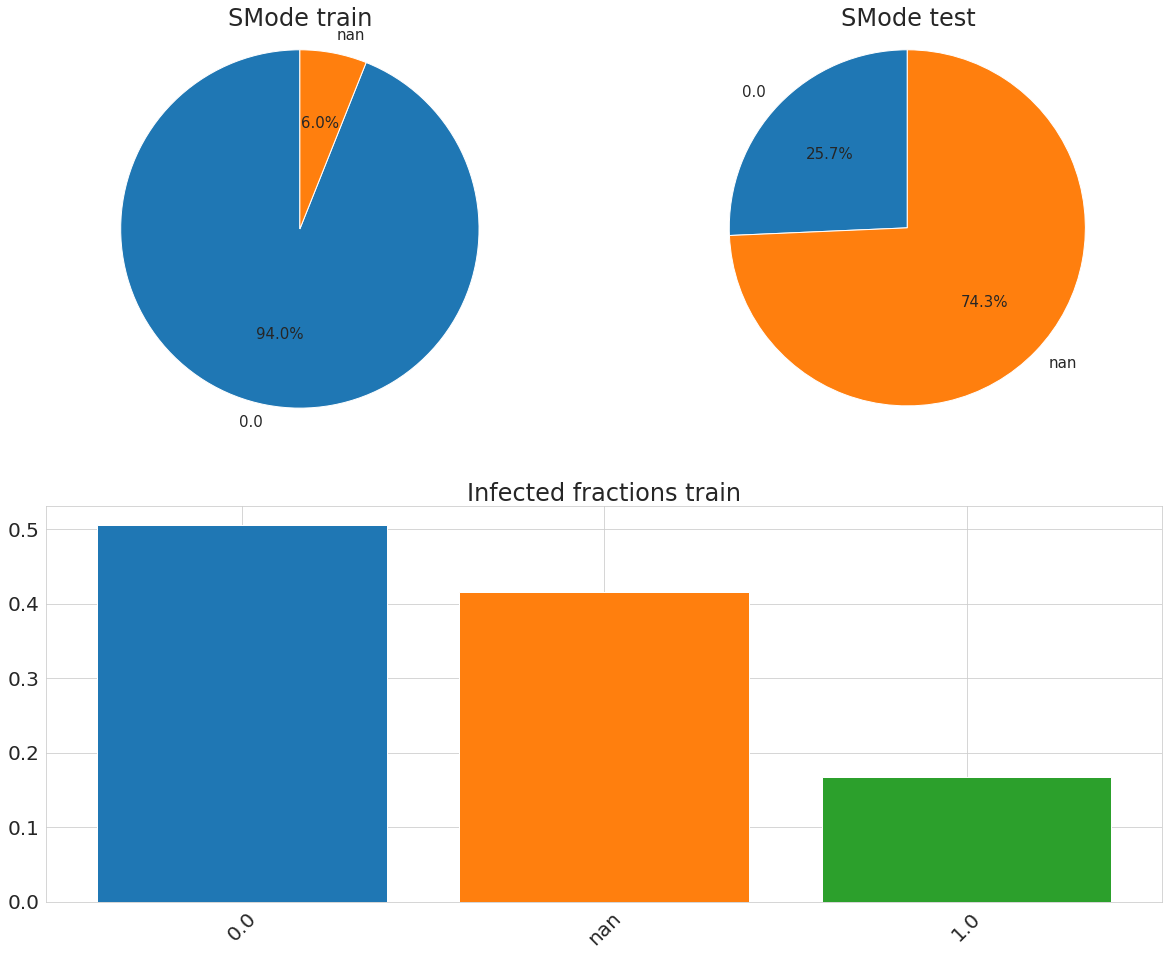

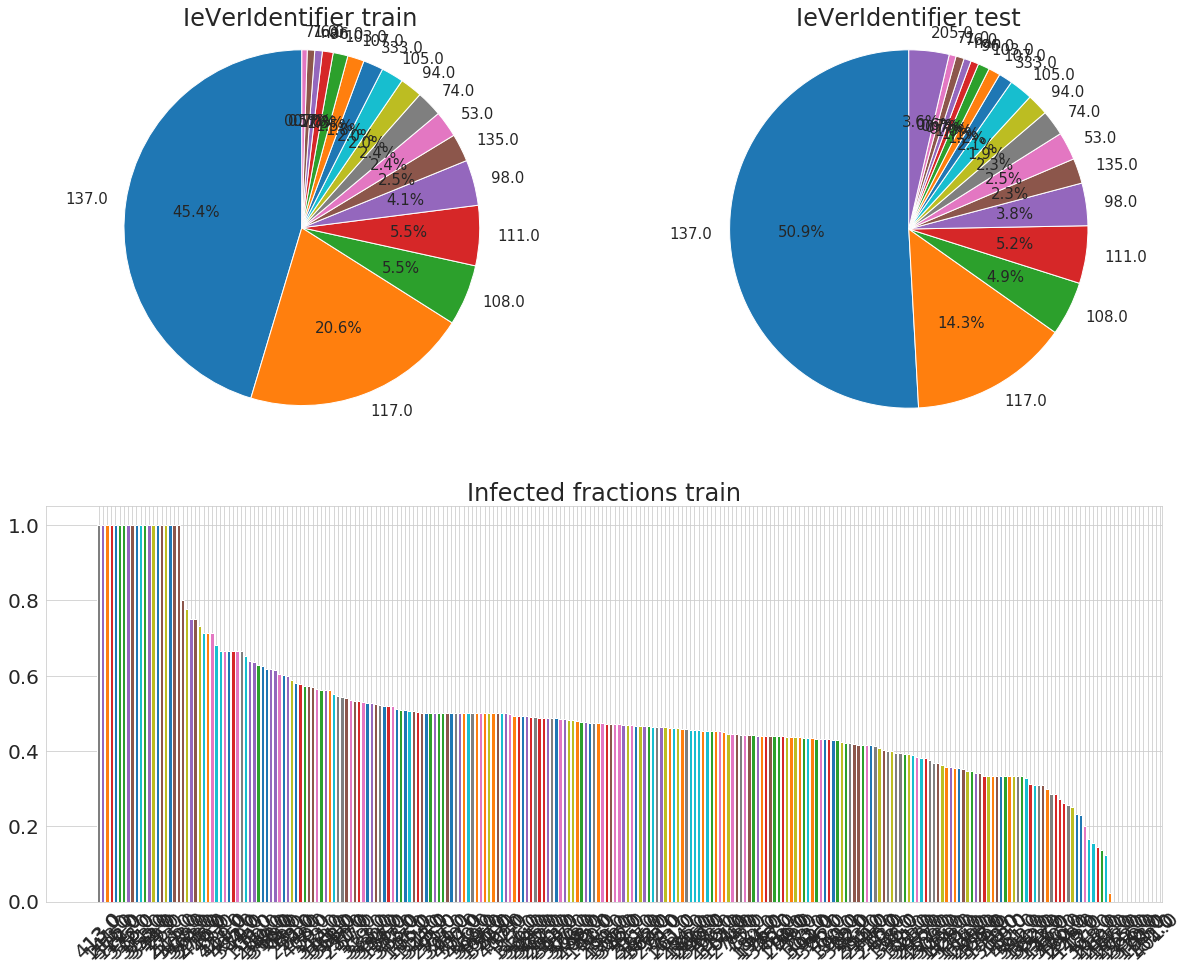

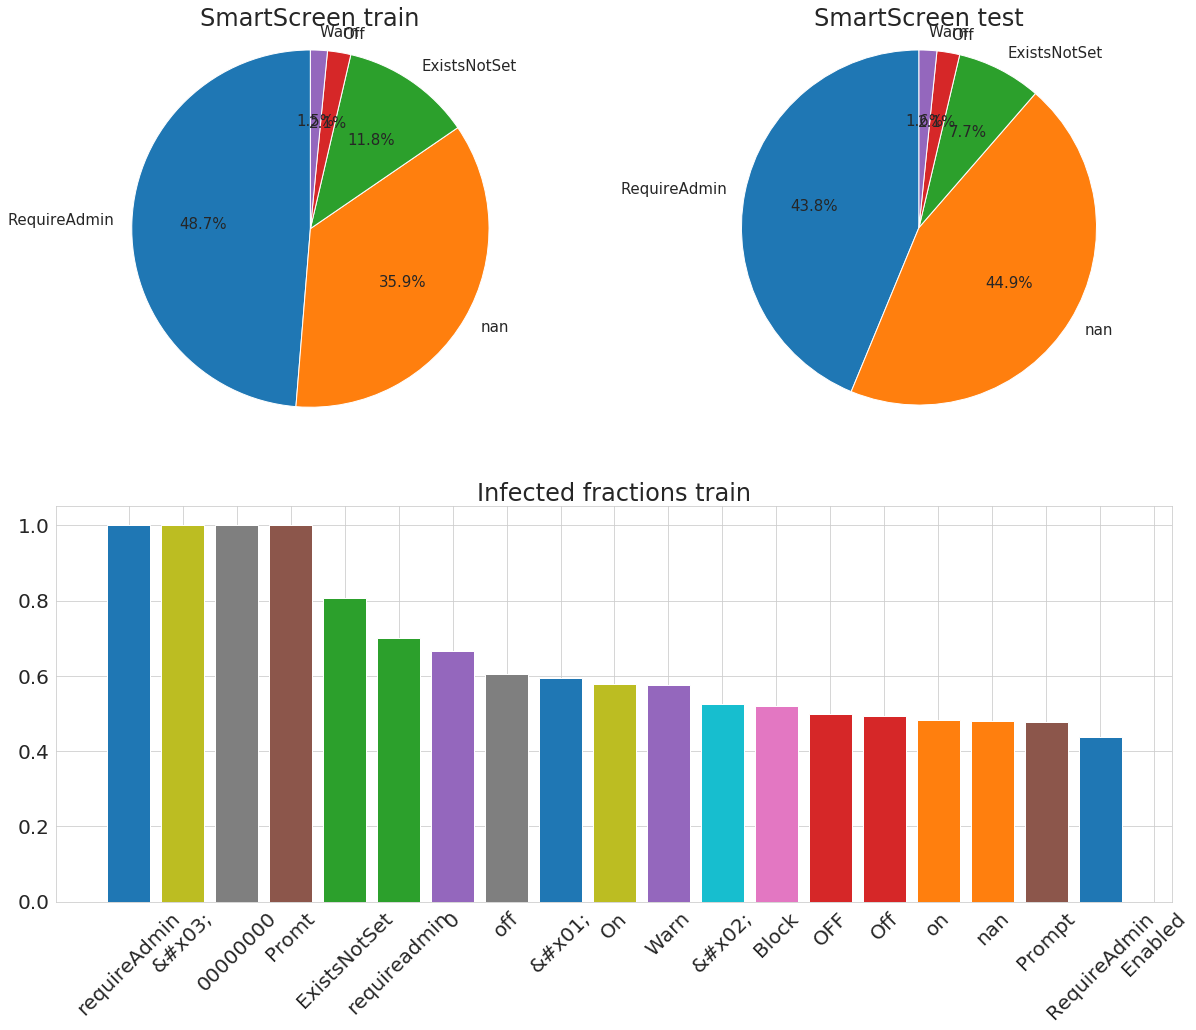

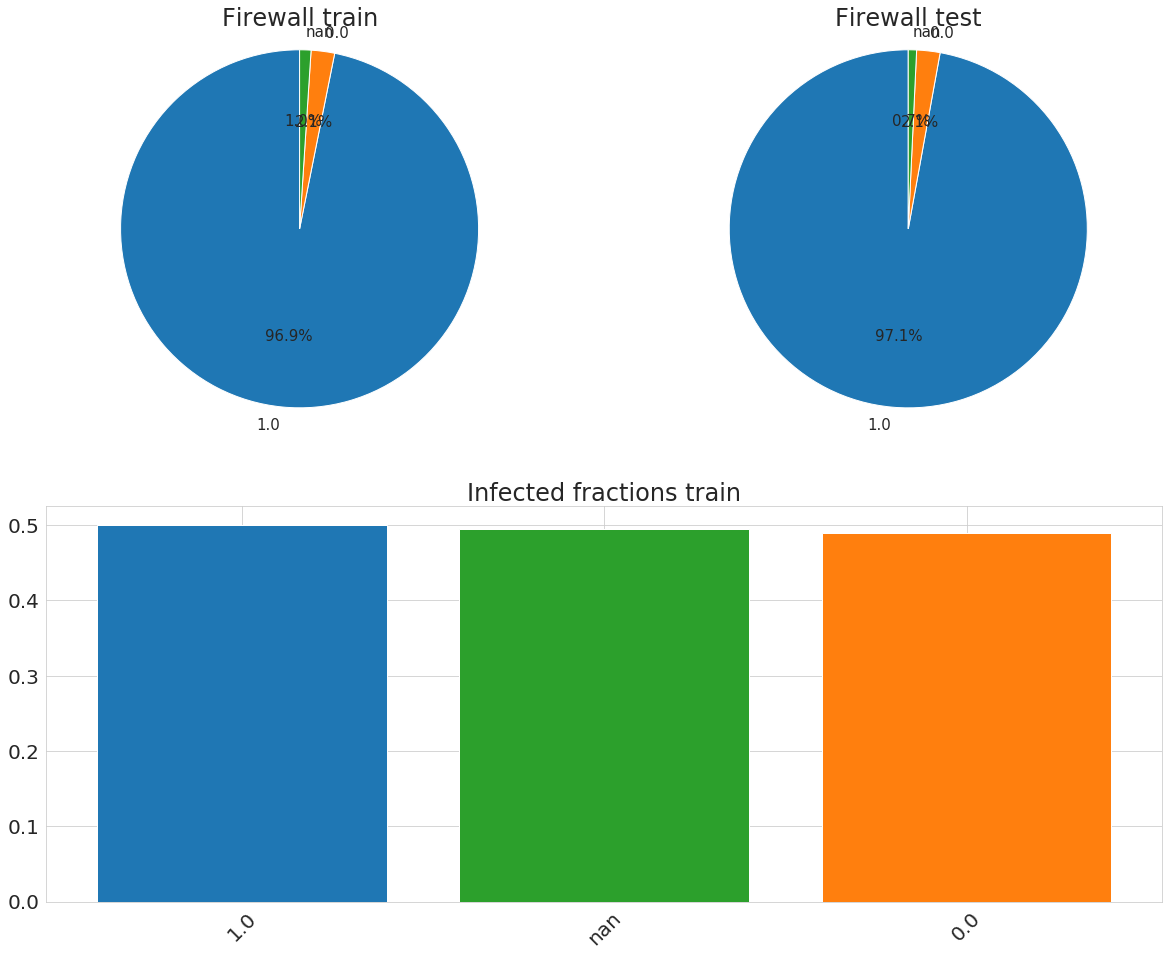

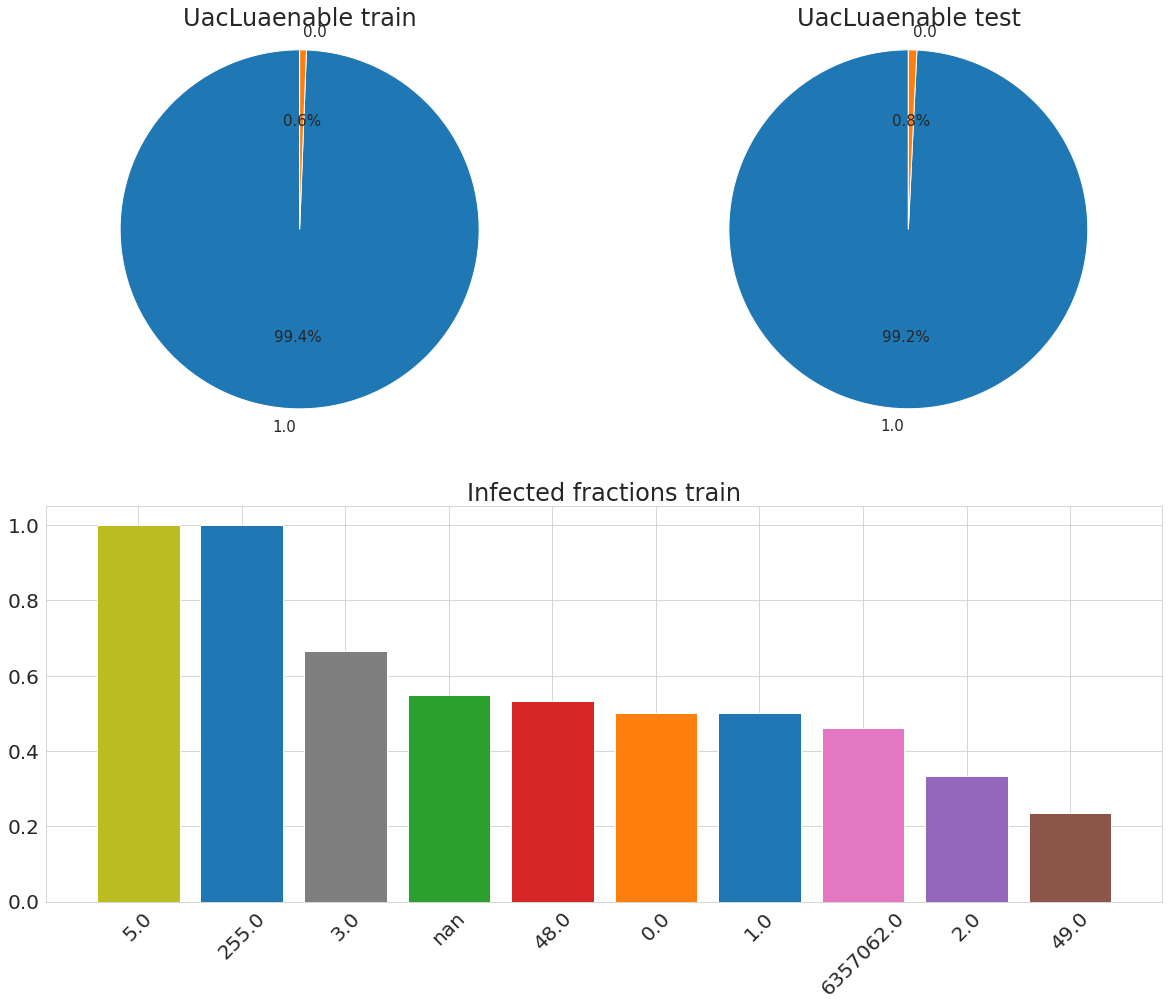

In [35]:
for col in feature[24:34]:
    my_graphs1(col)

#### Devise Census

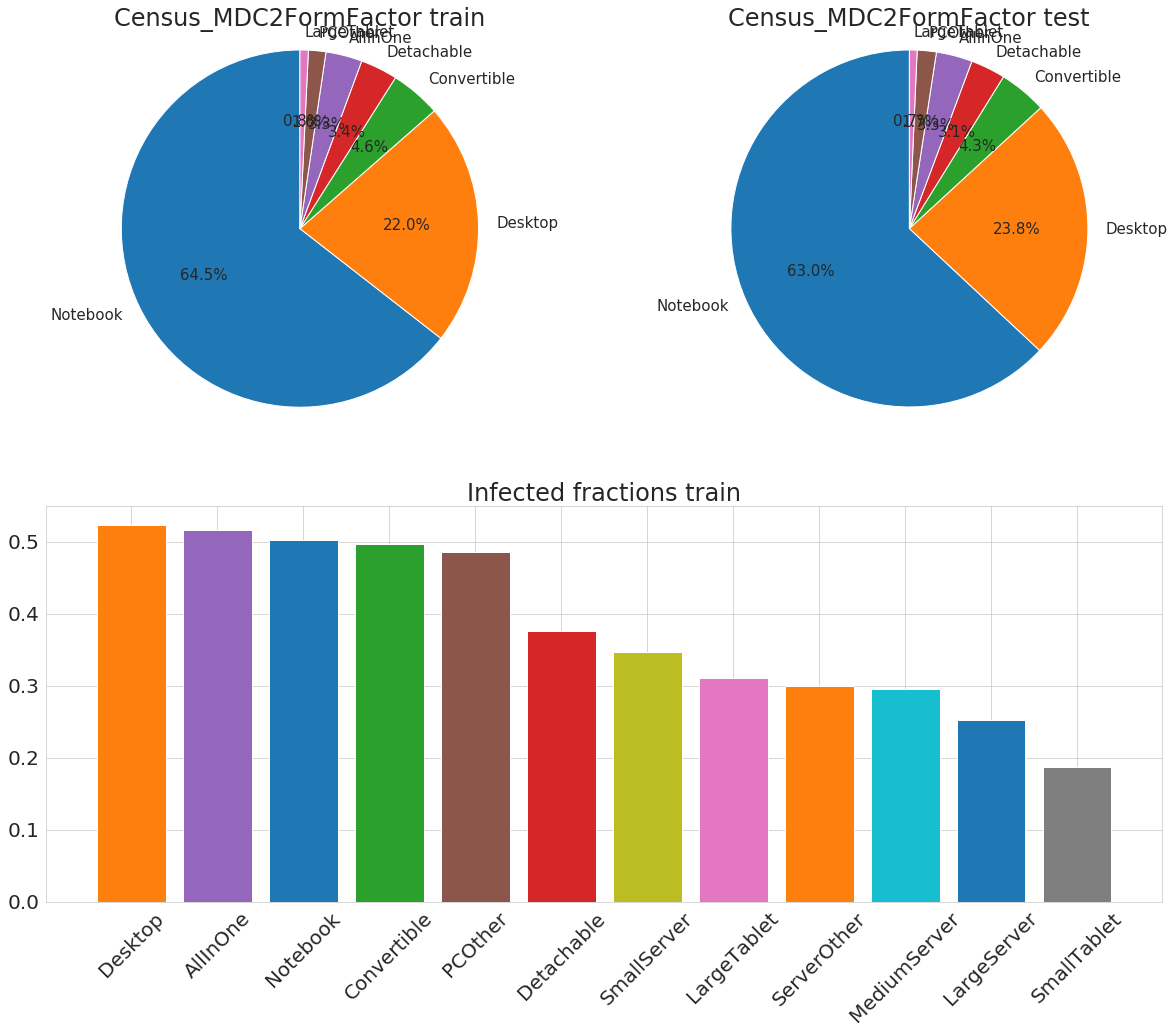

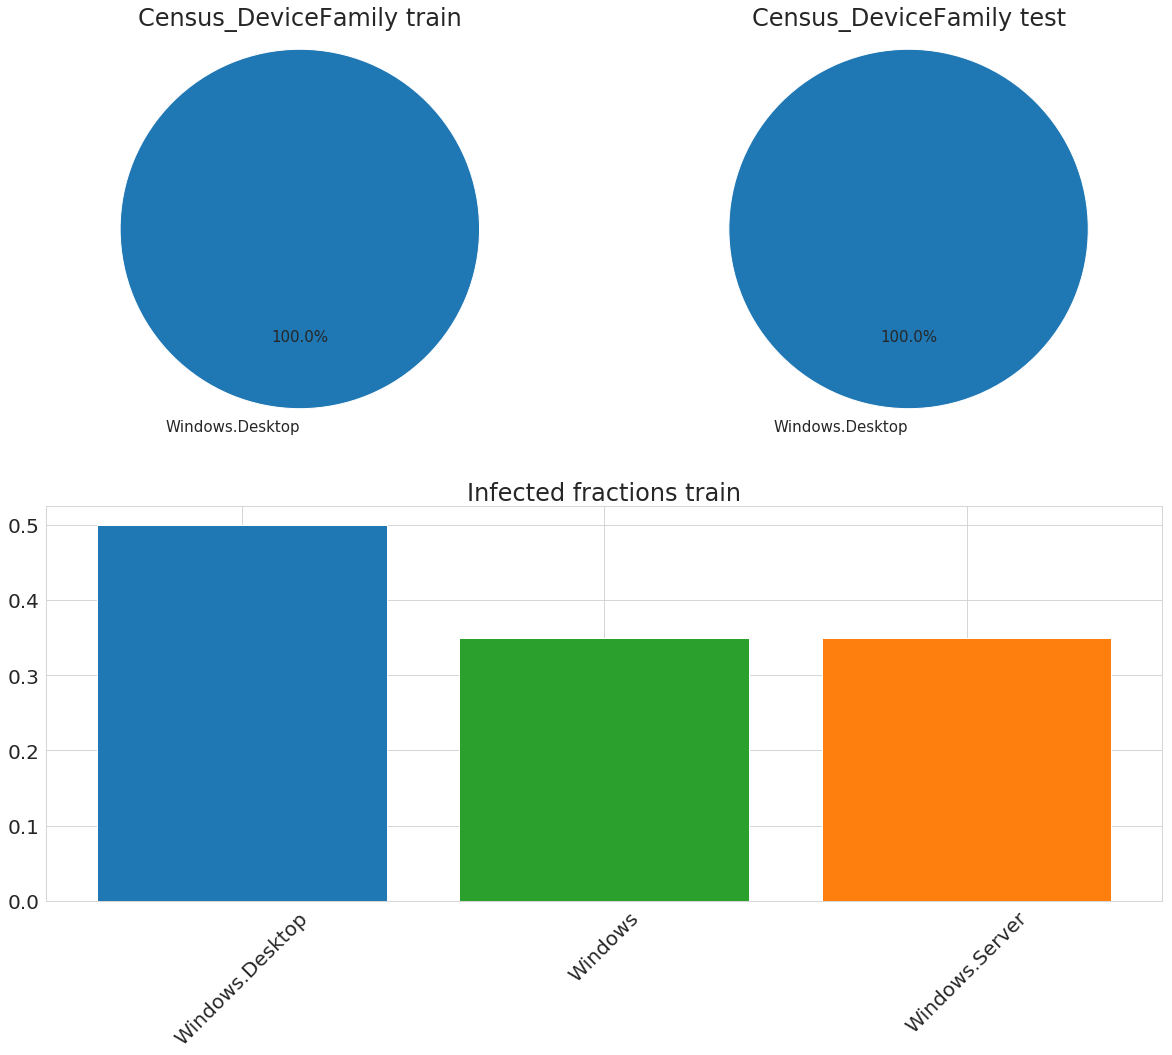

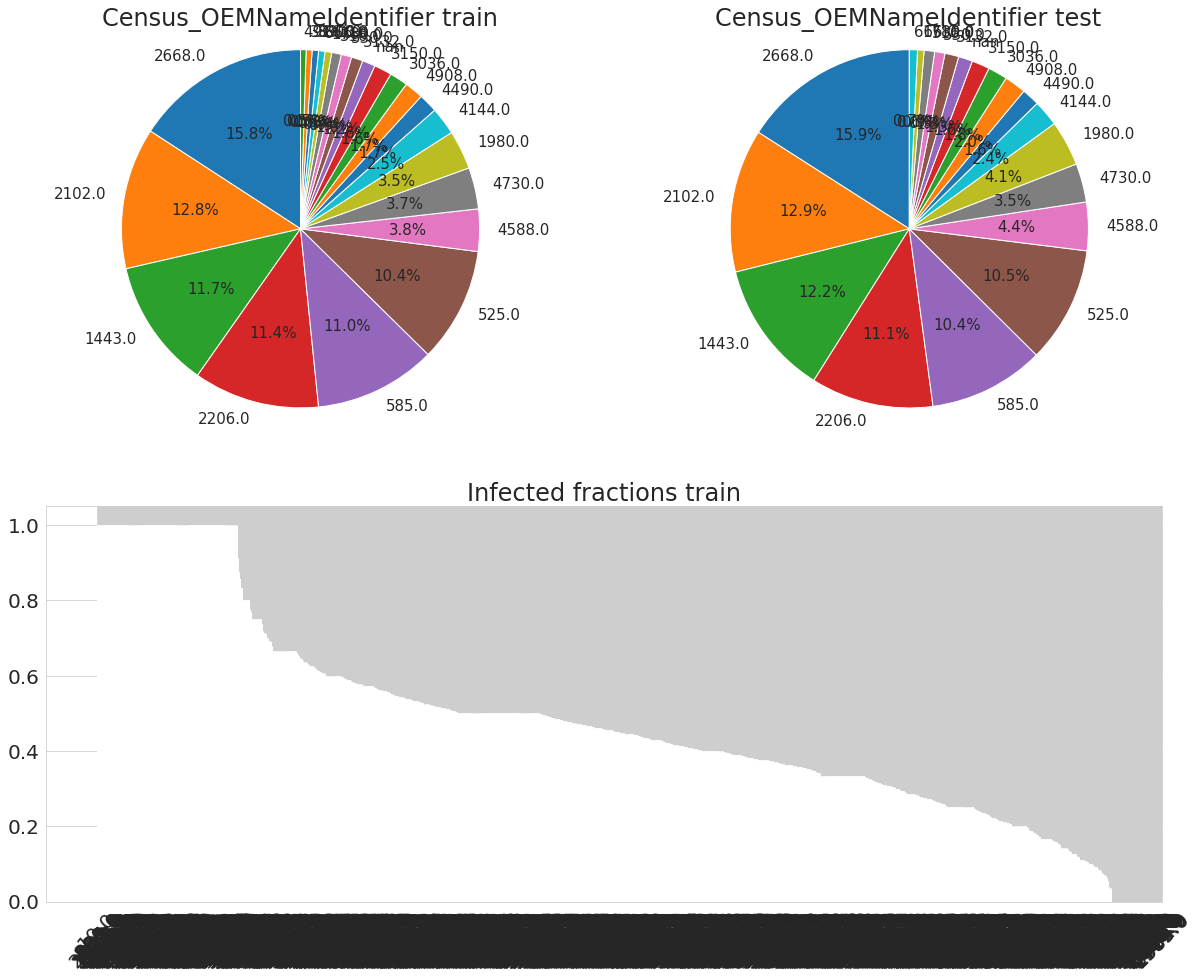

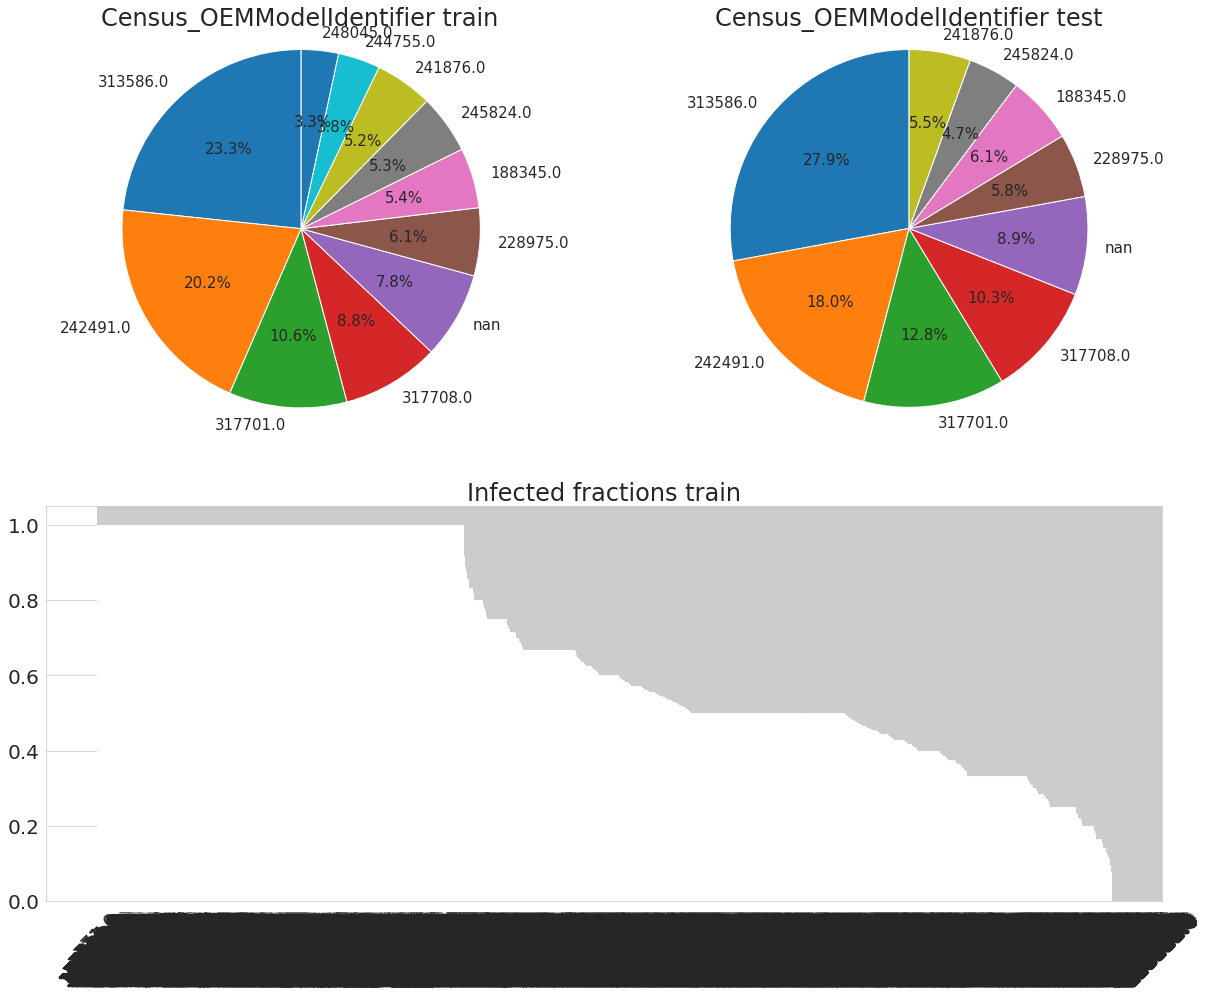

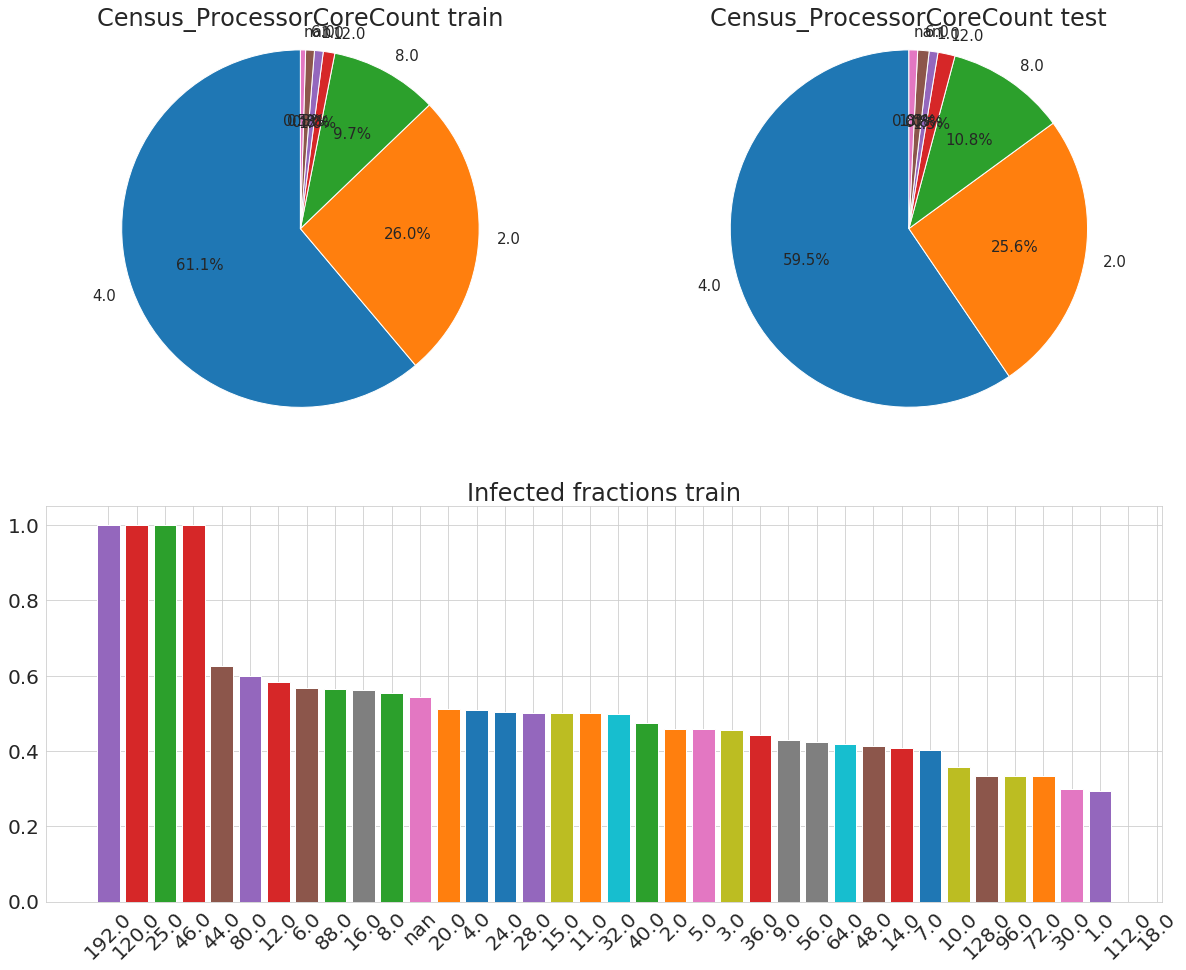

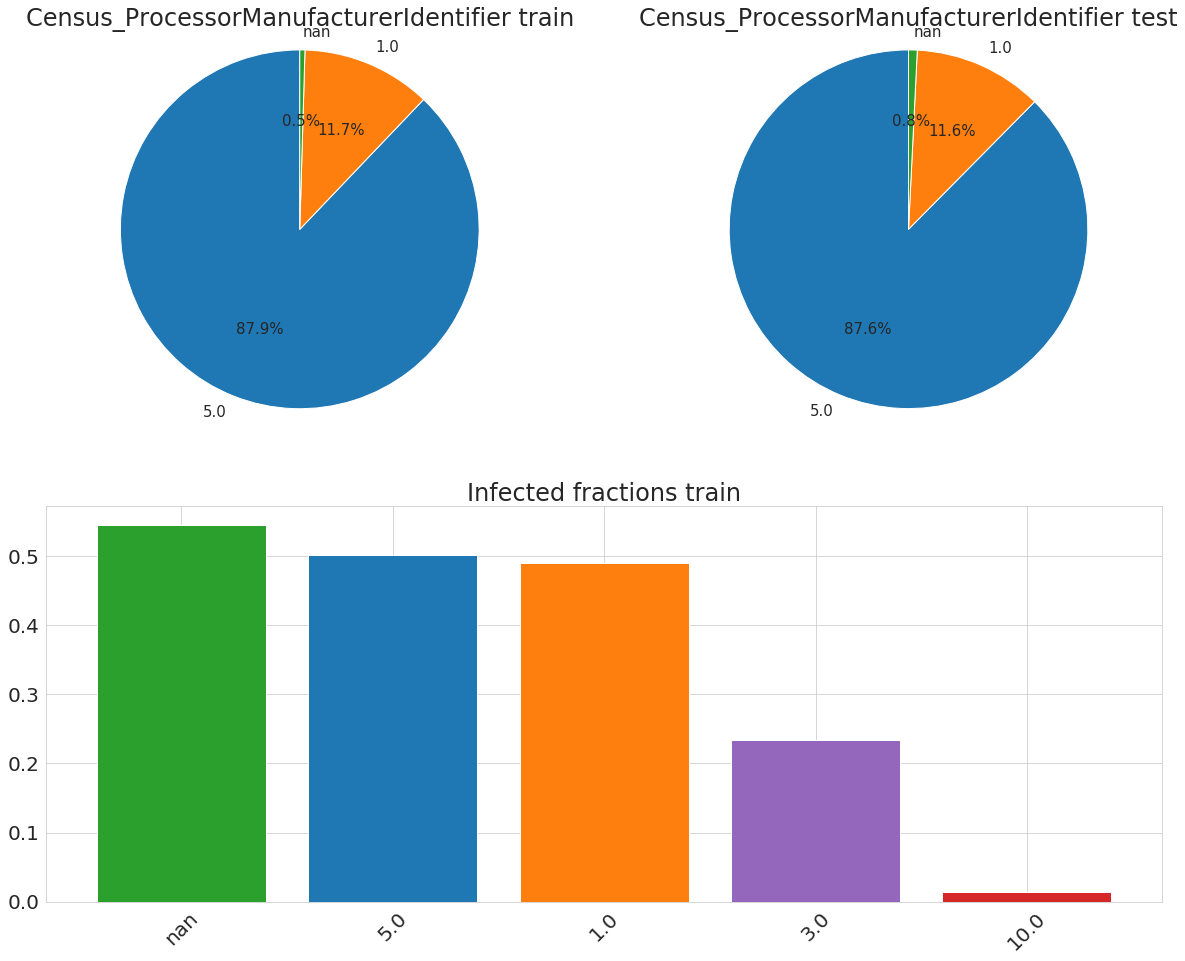

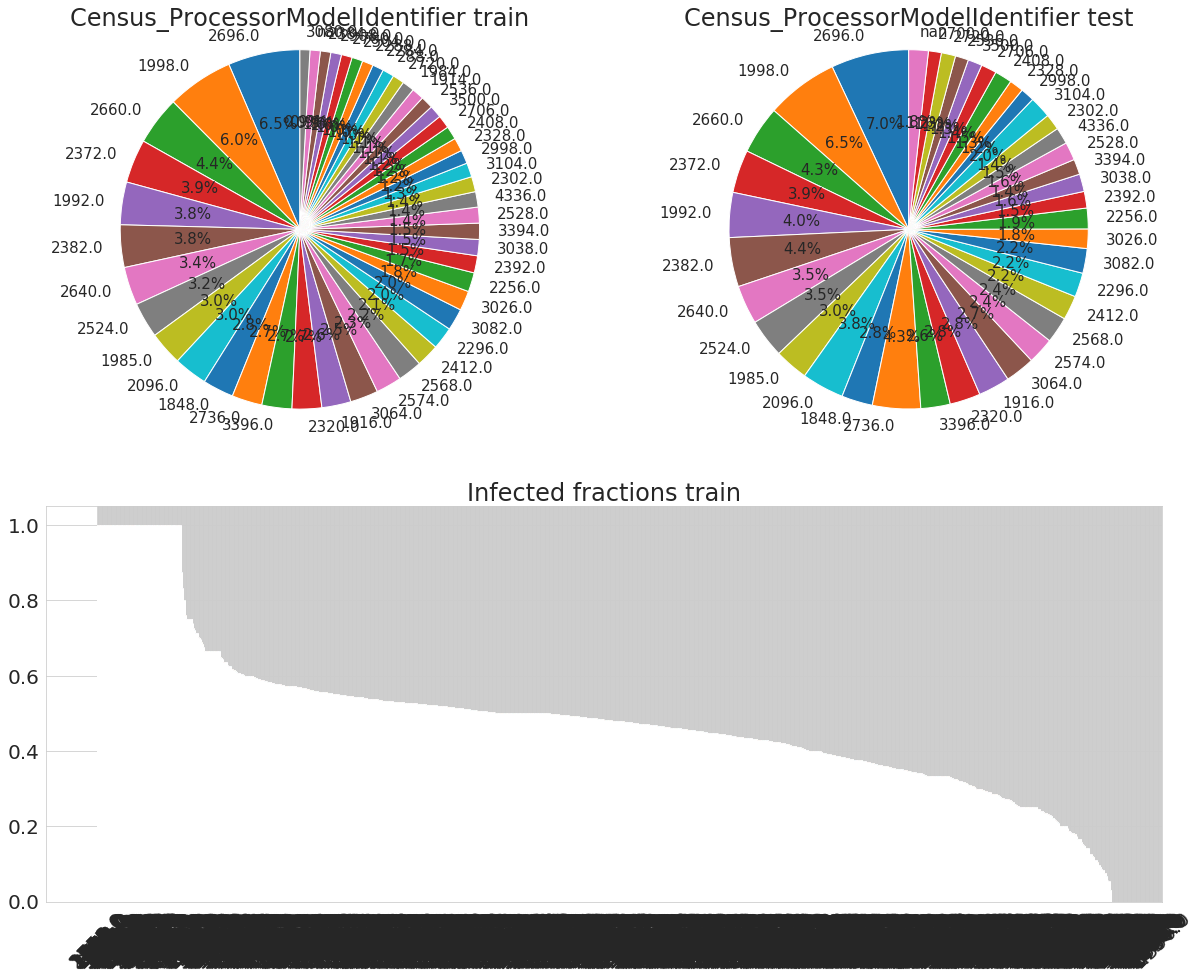

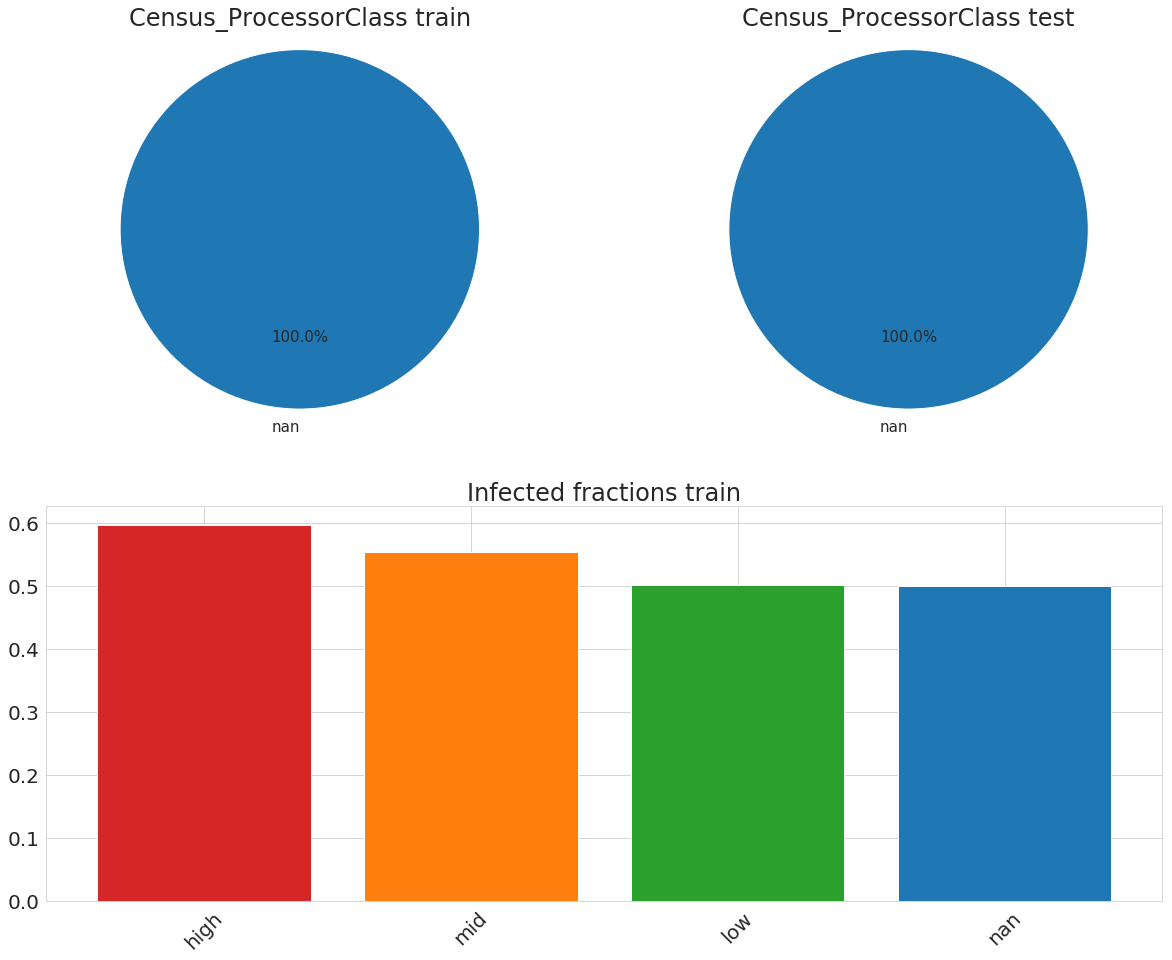

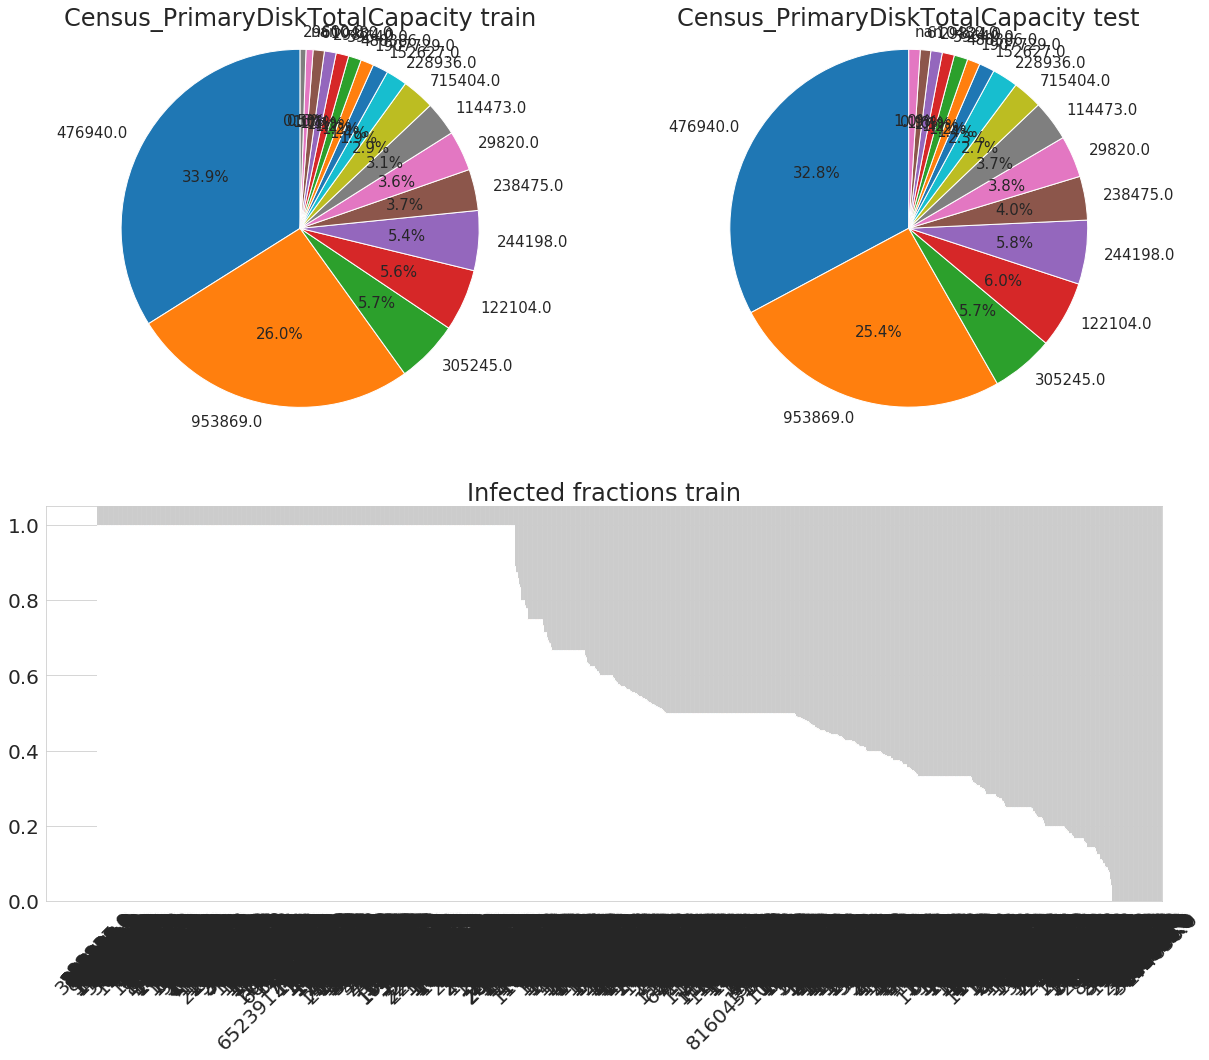

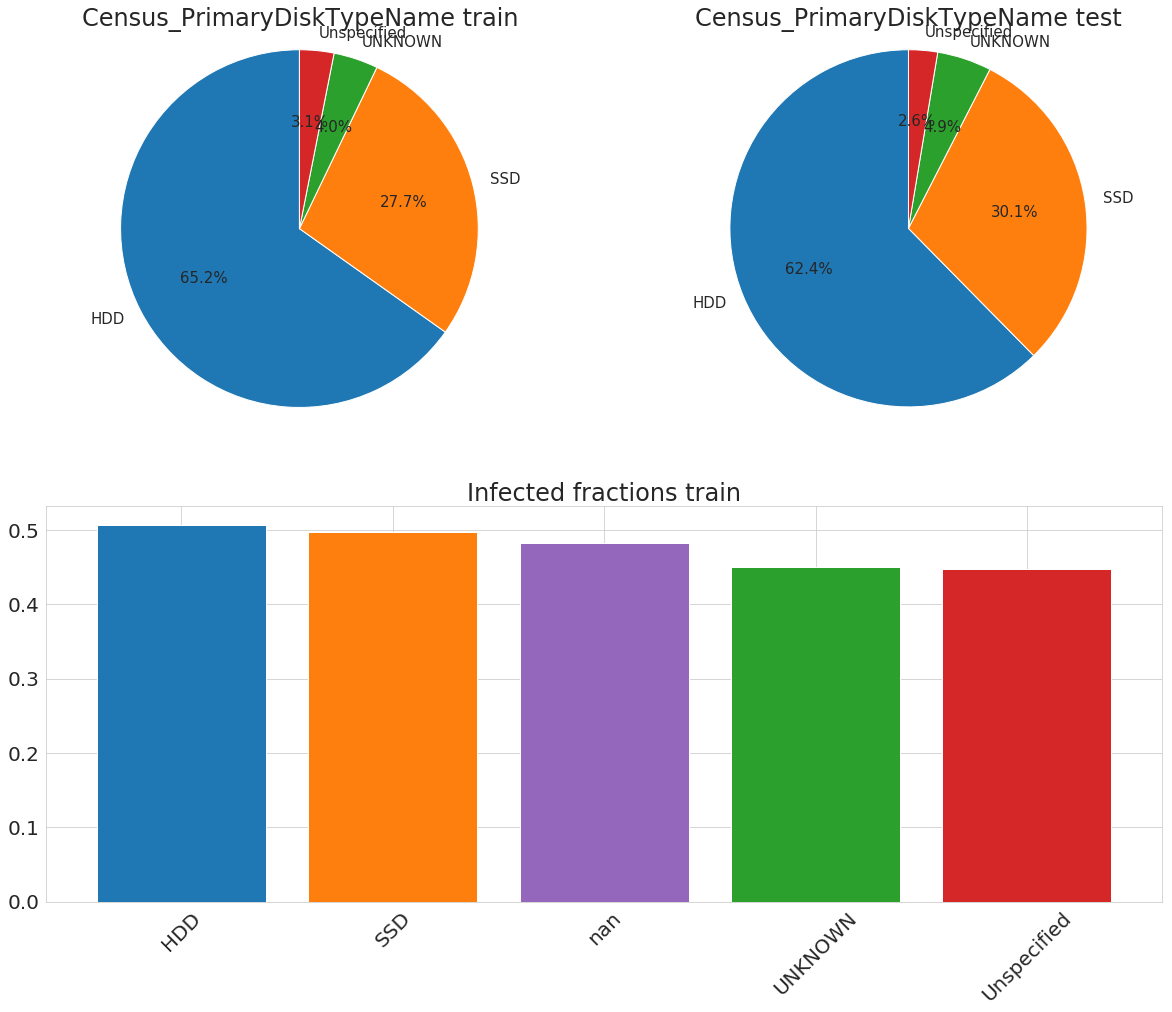

In [ ]:
for col in feature[34:]:
    my_graphs1(col)